<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h2>Predicting Birthweight: Saving Infant Lives Through Data Science</h2><br>
<h4>DAT-5329 | Introduction to Machine Learning & AI (March, 2024)</h4><br>
Author: <a href="https://www.linkedin.com/in/cla-wiese/" target="_blank">Constantin L. A. Wiese</a><br><br>
Hult International Business School<br>

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h2>Introduction</h2><br>
Low birth weight, defined by the World Health Organization (WHO) as less than 2,500 grams, is associated with higher infant mortality, inhibited growth, and cognitive development, with infants approximately 20 times more likely to die compared to heavier infants (<a href="https://www.who.int/data/nutrition/nlis/info/low-birth-weight" target="_blank">WHO, 2023</a>). Given these severe health risks, accurately predicting low birth weight is crucial to mitigating complications. This analysis develops a machine learning model based on relevant maternal health and pregnancy factors to predict low birth weight. By identifying mothers at the highest risk of having low birthweight babies, interventions and additional care can be targeted to those who need it most. The model results will equip public health professionals with a vital tool in the fight to reduce infant mortality and long-term adverse health outcomes.

<h2>Part I: Imports, Data Check, & Creating Visualization Functions</h2>

The data is loaded and checked. Visualization functions are defined.

In [1]:
# Standard libraries
import datetime                   # time data for submissions
import warnings                   # suppressing warnings

# Data manipulation and visualization libraries
import matplotlib.pyplot as plt   # data visualization
import numpy as np                # mathematical essentials
import pandas as pd               # data science essentials
import seaborn as sns             # enhanced data viz

# Preprocessing and model selection libraries
from sklearn.model_selection import RandomizedSearchCV  # hyperparameters
from sklearn.model_selection import train_test_split    # train-test split
from sklearn.preprocessing import power_transform       # yeo-johnson
from sklearn.preprocessing import StandardScaler        # standard scaler

# Machine learning models
from sklearn.ensemble import GradientBoostingClassifier # gbm
from sklearn.ensemble import RandomForestClassifier     # random forest
from sklearn.linear_model import LogisticRegression     # logistic
from sklearn.linear_model import RidgeClassifier        # ridge
from sklearn.neighbors import KNeighborsClassifier      # knn
from sklearn.tree import DecisionTreeClassifier         # decision tree

# Model visualization
from sklearn.tree import plot_tree                      # tree plots

# Model evaluation metrics
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.metrics import precision_score, recall_score, roc_auc_score

# Classification-specific libraries
import phik                                             # phi coefficient
import statsmodels.formula.api as smf                   # modeling

# suppressing warnings
warnings.filterwarnings("ignore")

# creating a results list
model_results = pd.DataFrame([], columns =
                     ["Model Name", "train_RSQ", "test_RSQ", "tt_gap",
                     "AUC Score", "Precision", "Sensitivity", "Specificity",
                     "True n_bwght",    # True Negatives
                     "False low_bwght", # False Positives
                     "False n_bwght",   # False Negatives
                     "True low_bwght"]) # True Positives

In [2]:
# setting pandas print options
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

# specifying file paths
modeling_data = "./datasets/birthweight.csv"
testing_data = "./datasets/kaggle_test_data.csv"

# calling model data
df_model = pd.read_csv(filepath_or_buffer = modeling_data,
                       header             = 0,
                       index_col          = "obs_id",
                       na_values          = None,
                       keep_default_na    = True)

# calling test data
df_test = pd.read_csv(filepath_or_buffer = testing_data,
                       header             = 0,
                       index_col          = "obs_id",
                       na_values          = None,
                       keep_default_na    = True)

# concatenating datasets together for mv analysis and feature engineering
df_model["set"] = "Not Kaggle"
df_test ["set"] = "Kaggle"

# concatenating both datasets together for mv and feature engineering
df = pd.concat(objs = [df_model, df_test],
               axis = 0,
               ignore_index = False)

# specifying dictionary
data_dict = {"feature number": [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                10, 11, 12, 13, 14, 15, 16, 17, 18], 
             "label": ["mage", "meduc", "monpre", "npvis", "fage", "feduc",
                       "omaps", "fmaps", "cigs", "drink", "male", "mwhte",
                       "mblck", "moth", "fwhte", "fblck", "foth", "bwght"],
             "description": ["mother's age in years",
                             "mother's education in years",
                             "month of pregnancy that prenatal care began",
                             "total number of prenatal visits",
                             "father's age in years",
                             "father's education in years",
                             "one minute apgar score",
                             "five minute apgar score",
                             "average cigarettes per day consumed by mother",
                             "average drinks per week consumed by mother",
                             "1 if baby male",
                             "1 if mother white",
                             "1 if mother black",
                             "1 if mother is not black or white",
                             "1 if father white",
                             "1 if father black",
                             "1 if father is not black or white",
                             "birthweight in grams"]}
# saving and printing dictionary
dictionary = pd.DataFrame(data_dict)

print(f"""
Dataset Size
------------------------
Observations: {df.shape[0]}
Features:     {df.shape[1]}
""") # formatting and printing the dimensions of the dataset

# identifying missing observation values in incomplete features
print(f"""
Missing Observations
-------------------------""")
print(len(df) - df.count()[df.count() != len(df)],"\n")

# displaying data dictionary
dictionary


Dataset Size
------------------------
Observations: 1832
Features:     19


Missing Observations
-------------------------
meduc      30
monpre      5
npvis      68
fage        6
feduc      47
omaps       3
fmaps       3
cigs      110
drink     115
bwght     184
dtype: int64 



,feature number,label,description
0,1,mage,mother's age in years
1,2,meduc,mother's education in years
2,3,monpre,month of pregnancy that prenatal care began
3,4,npvis,total number of prenatal visits
4,5,fage,father's age in years
5,6,feduc,father's education in years
6,7,omaps,one minute apgar score
7,8,fmaps,five minute apgar score
8,9,cigs,average cigarettes per day consumed by mother
9,10,drink,average drinks per week consumed by mother


In [3]:
df_mv = df.copy(deep = True) # saving original data

def histplot(feature, df = df, hue = None):
    """
    Function to create a histogram plot for a given feature.
    
    Parameters:
    - feature: The column name of the feature to plot.
    - df: The underlying dataset to use.
    - hue: Optional color coding.
    """
    # Setting figure size
    fig, ax = plt.subplots(figsize = (15, 4))
    
    # Developing a histogram plot
    sns.histplot(data = df, x = feature, hue = hue, fill = True)
    
    # Drawing mean and median lines
    plt.axvline(x     = df[feature].mean(),
                color = "red",
                label = "Mean",
                alpha = 0.5)
    plt.axvline(x     = df[feature].median(),
                color = "blue",
                label = "Median",
                alpha = 0.5)
    
    # Adding legend to the plot
    plt.legend()
    
    # Displaying the plot
    plt.tight_layout()
    plt.show()

def boxplot(feature, feature_2, df = df):
    """
    Function to create a box plot for two features.
    
    Parameters:
    - feature: The column name of the feature for the x-axis.
    - feature_2: The column name of the feature for the y-axis.
    - df: The underlying dataset to use.
    """
    # Setting figure size
    fig, ax = plt.subplots(figsize = (15, 4))
    
    # Developing a box plot
    sns.boxplot(data = df, x = feature, y = feature_2)
    
    # Displaying the plot
    plt.tight_layout()
    plt.show()

    
# imputation_check function to visualize imputation results

def imputation_check(feature):
    """
    This function visualizes the effect of imputation on a feature by plotting
    histograms before and after imputation.
    
    It takes in the feature name as input and plots two histograms with KDE:
     - In red: After imputation 
     - In black: Before imputation (with missing values)
     
    It also plots the mean values as vertical lines.
    
    This allows easy comparison to check if imputation has significantly
    altered the distribution.
    """
    # setting figure size
    fig, ax = plt.subplots(figsize = (15, 4))
    
    # histplot AFTER missing values
    sns.histplot(data  = df,
                 x     = feature,
                 fill  = True,
                 color = "red",
                 kde   = True)
    
    # histplot BEFORE missing values
    sns.histplot(data  = df_mv,
                 x     = feature,
                 fill  = True,
                 color = "black",
                 kde   = True)
    
    # median lines
    plt.axvline(df[feature].median(), color = "red", label = "After", alpha = 0.5)
    plt.axvline(df_mv[feature].median(), color = "black", label = "Before", alpha = 0.5)
    
    # adding legend to the plot
    plt.legend()
    
    # displaying the plot
    plt.title (label  = f"Imputation Results ({feature.capitalize()})")
    plt.xlabel(xlabel = feature.capitalize())
    plt.ylabel(ylabel = "Frequency")
    plt.tight_layout()
    plt.show()

<h2>Part II: Exploratory Data Analysis, Data Preprocessing, & Feature Engineering</h2>

<h3>Dropping Pre-Event Features</h3>

In [4]:
df.drop(["fmaps", "omaps"], inplace = True, axis = 1) # dropping pre-event features

The Apgar score is excluded because it is measured after birth; only features available before the event can be legitimately utilized to predict low birth weight in an interpretable model.

<h3>Flagging Missing Values</h3>

In [5]:
for col in df.columns:  # looping to flag missing value features
    if df[col].isnull().sum() > 0: # checking missing values existance
        # Create a new column with 'm_' prefix indicating missing values
        df["m_" + col] = df[col].isnull().astype(int)
        
df.drop("m_bwght", inplace = True, axis = 1) # dropping missing bwght

Even when data is missing from a dataset, that does not make the dataset worthless. The gaps in the data can provide essential insights for thoroughly analyzing the data. A strategic approach is creating dummy variables for features with absent values, which preserves the nuanced details conveyed by those omissions before filling in the gaps. This method applies to variables `meduc`,`monpre`, `npvis`, `fage`, `feduc`, `omaps`, `fmaps`,`cigs`, and `drink`. There, missing values exist.

In [6]:
df.info() # checking EDA needs

<class 'pandas.core.frame.DataFrame'>
Index: 1832 entries, id_0001 to id_0302
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   mage      1832 non-null   int64  
 1   meduc     1802 non-null   float64
 2   monpre    1827 non-null   float64
 3   npvis     1764 non-null   float64
 4   fage      1826 non-null   float64
 5   feduc     1785 non-null   float64
 6   cigs      1722 non-null   float64
 7   drink     1717 non-null   float64
 8   male      1832 non-null   int64  
 9   mwhte     1832 non-null   int64  
 10  mblck     1832 non-null   int64  
 11  moth      1832 non-null   int64  
 12  fwhte     1832 non-null   int64  
 13  fblck     1832 non-null   int64  
 14  foth      1832 non-null   int64  
 15  bwght     1648 non-null   float64
 16  set       1832 non-null   object 
 17  m_meduc   1832 non-null   int64  
 18  m_monpre  1832 non-null   int64  
 19  m_npvis   1832 non-null   int64  
 20  m_fage    1832 non-null   

<h3>Missing Values Imputation</h3>
<h4>Education in Years (meduc & feduc)</h4>

In [7]:
# calculating missing data percentage
total = df.shape[0]
missing_m = df["meduc"].isna().sum()
missing_pct_m = missing_m / total * 100

print(f"Percentage of Missing Mother's Education in Years Data: {missing_pct_m:.2f}%")

# calculating missing data percentage
missing_f = df["feduc"].isna().sum()
missing_pct_f = missing_f / total * 100
print(f"Percentage of Missing Father's Education in Years Data: {missing_pct_f:.2f}%")

Percentage of Missing Mother's Education in Years Data: 1.64%
Percentage of Missing Father's Education in Years Data: 2.57%


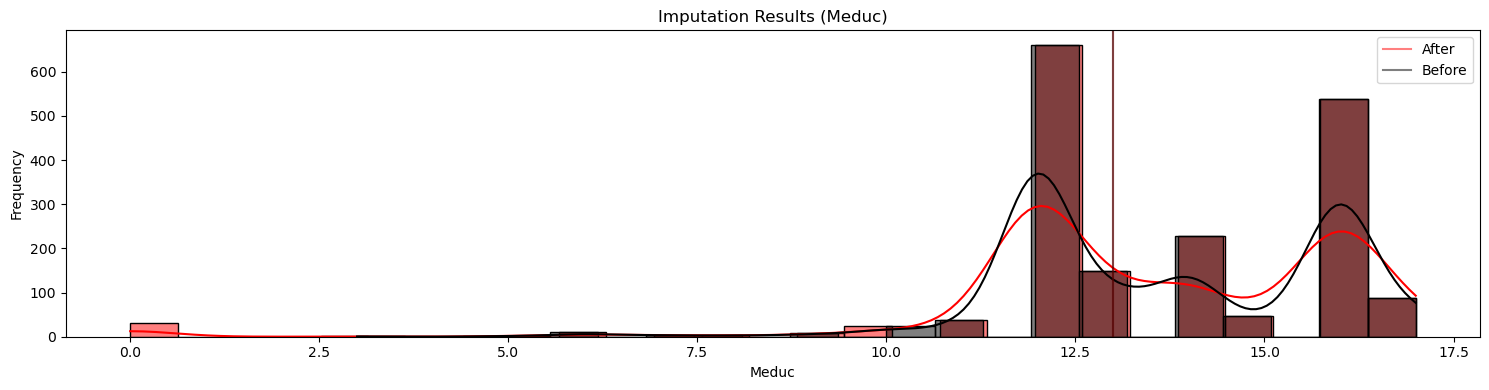

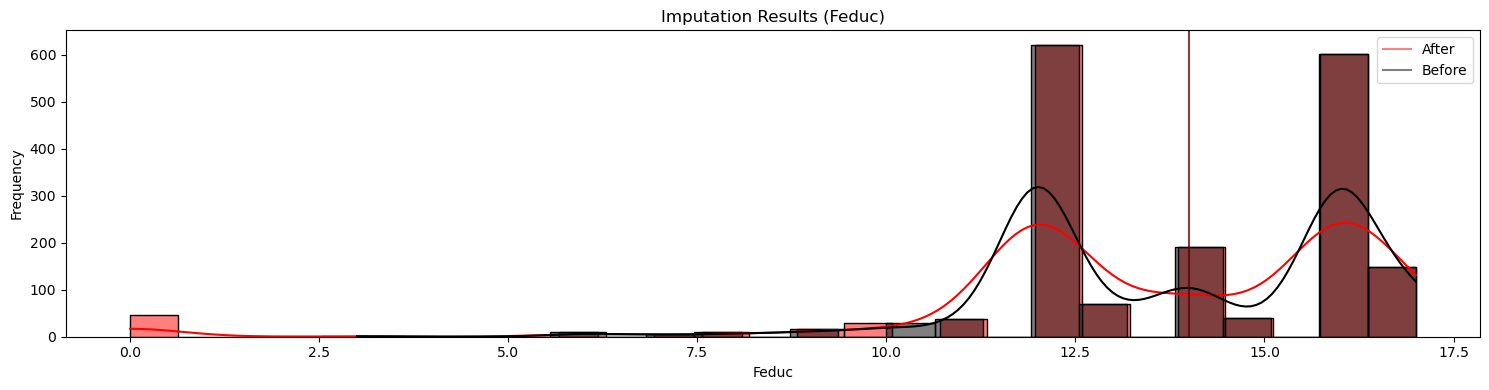

In [8]:
# imputing meduc
df["meduc"] = df["meduc"].fillna(0)
imputation_check(feature = "meduc") # user defined function to check imputation

# imputing feduc
df["feduc"] = df["feduc"].fillna(0)
imputation_check(feature = "feduc") # user defined function to check imputation

The majority of mothers and fathers have completed their high school education. Some have gone on to receive further education beyond that. In the available data, all individuals have at least three years of education, which is unrealistic. Unfortunately, some people always slip through the cracks in the education system. As a result, all missing values will be imputed with 0 years of education, assuming that in these cases, there is no information available regarding their education because they did not receive formal schooling. It is interesting to note that more men than women lack education according to this approach. Imputing 0 years for missing values, although a simplistic assumption, allows to account for the possibility of no formal education in a quantifiable way within the dataset. Further investigation into the true causes and patterns of missing data could provide additional nuance, but this approach serves as a reasonable starting point given the information available.

As expected, the distribution of both education variables changes only marginally after imputing missing values with zero years of education. The median remains the same, with men, on average, receiving slightly more education than women. However, the proportion without any formal education is higher for men. Both distributions shift slightly. Imputing zero years for missing data on education has a minor impact on the location and shape of the distributions for maternal and paternal education. The central tendency measured by the median is unaffected, suggesting imputation does not drastically alter overall education levels. The slight increase in those with no formal schooling reflects the assumption embedded in the imputation approach.

<h4>Month of Pregnancy that Prenatal Care Began (monpre)</h4>

In [9]:
# calculating missing data percentage
missing_monpre = df["monpre"].isna().sum()
missing_pct_monpre = missing_monpre / total * 100
print(f"Percentage of Missing Monpre Data: {missing_pct_monpre:.2f}%")

Percentage of Missing Monpre Data: 0.27%


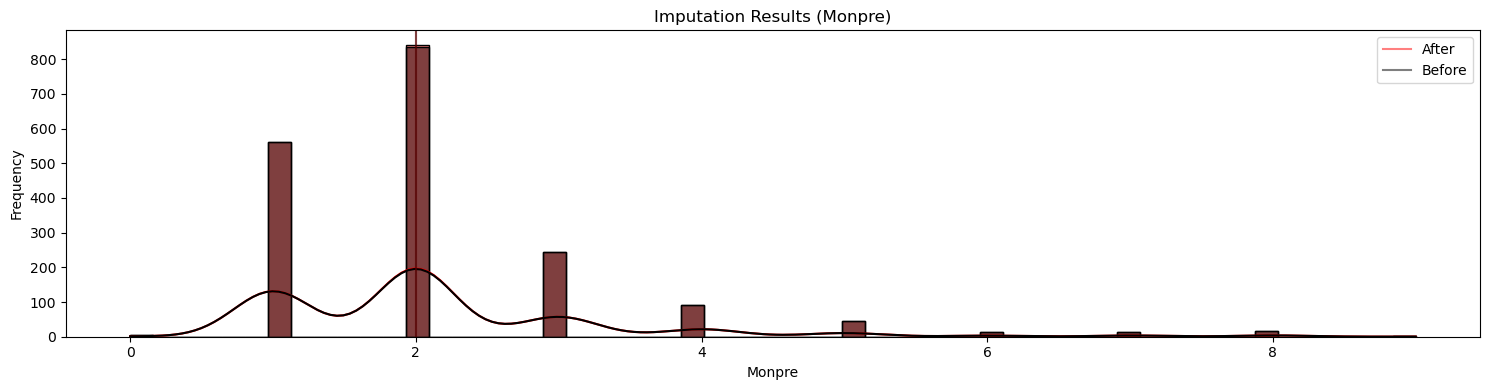

In [10]:
# imputing monpre
df["monpre"] = df["monpre"].fillna(df.loc[df["monpre"].notnull(), "monpre"].median())

imputation_check("monpre") # user defined function to check imputation

The proportion of missing data for the timing of initial prenatal care is negligible. Subsequently, the median is utilized to impute these sparse missing values. The rationale for using the median rather than the mean is rooted in the distribution of the timing variable. With most women commencing prenatal care during a concentrated period of gestation, the data exhibits a skewed rather than symmetric distribution. The median provides a more representative measure of central tendency in this scenario.

<h4>Total Number of Prenatal Visits (npvis)</h4>

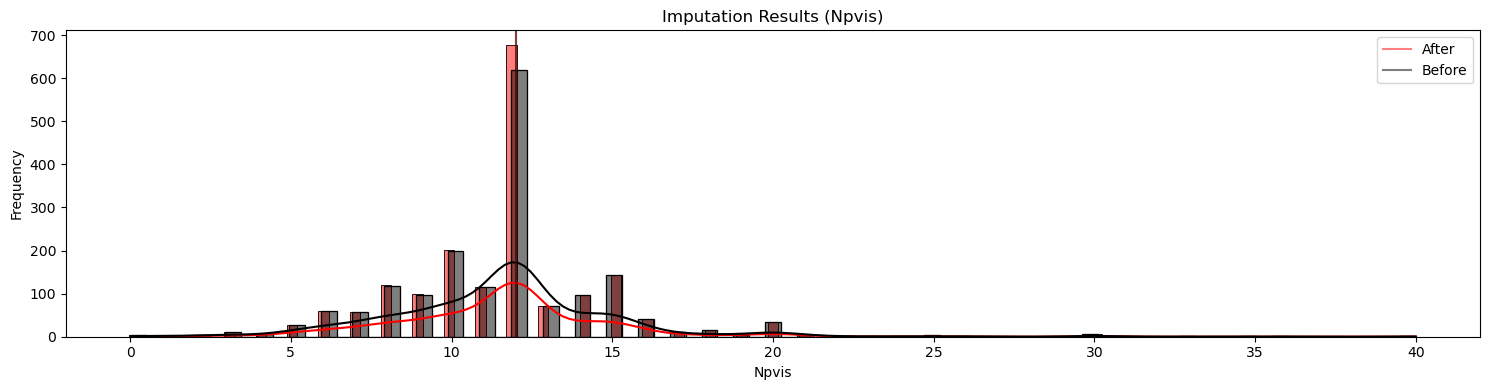

In [11]:
# Calculate medians grouped by monpre 
npvis_medians = df.groupby("monpre")["npvis"].median().to_dict() 

# Impute missing values
df["npvis"] = df["npvis"].fillna(df["monpre"].map(npvis_medians))

imputation_check("npvis") # user defined function to check imputation

The number of prenatal visits has a median of 12 but substantial variance, ranging from 0 to over 40. While 12 is a reasonable proxy, the distribution exhibits a notable spread. A long right tail reflects a minority with high engagement, with some outliers at 40 visits. The left tail extends to 0, likely indicating missed prenatal care. With dispersion encompassing comprehensive to potentially inadequate care, the data shows extensive diversity in visit frequency.

The missing values in the number of prenatal visits (`npvis`) are imputed using `monpre`-specific medians rather than the overall median. The data is first grouped by month prenatal care began (`monpre`), and the median `npvis` are calculated per group. These `monpre`-median pairs are stored in a dictionary. For rows with missing `npvis`, the corresponding median is determined via the `monpre` mapping and used for imputation. This tailored imputation accounts for the correlation between the timing of care and the number of visits, helping preserve the data structure. Imputing missing data by relevant subgroups in this way limits introduced bias compared to utilizing a single value.

<h4>Father's Age in Years (fage)</h4>

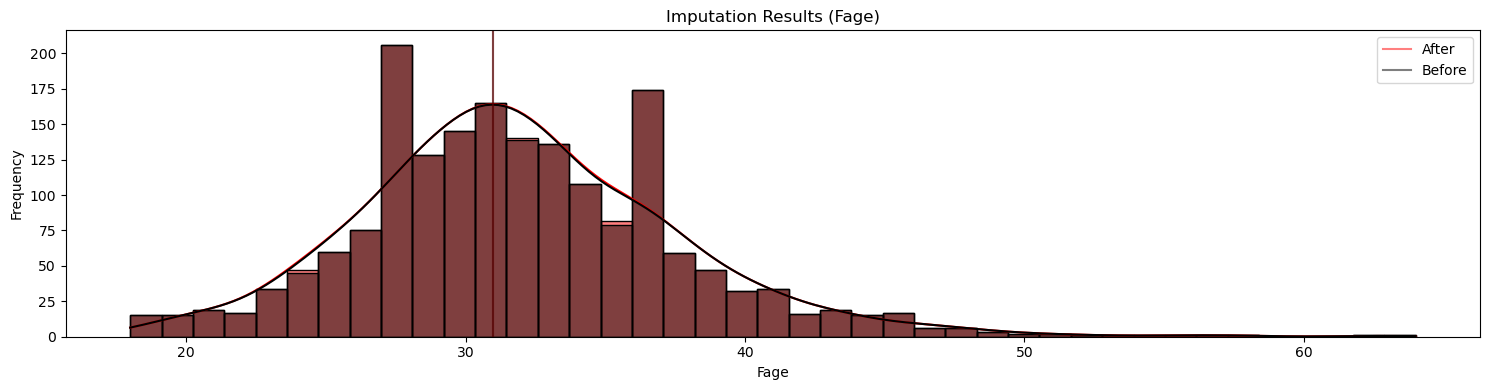

In [12]:
# Calculate medians grouped by mage
fage_medians = df.groupby("mage")["fage"].median().to_dict() 

# Impute missing values
df["fage"] = df["fage"].fillna(df["mage"].map(fage_medians))

imputation_check("fage") # user defined function to check imputation

The fathers' age variable contained missing values. Rather than imputing with the overall median, age-specific medians were calculated by maternal age to maintain correlations between parental ages. People often have partners of similar age. Mother's age grouped the data, and the median paternal age was determined for each subset. The mother's age was the age to identify the appropriate median for the missing father's age, which was then utilized for imputation. Basing imputed values on the mother's age in this way preserved the expected correlation between maternal and paternal age when filling in missing data.

<h4>Average Cigarettes per Day Consumed by the Mother (cigs)</h4>

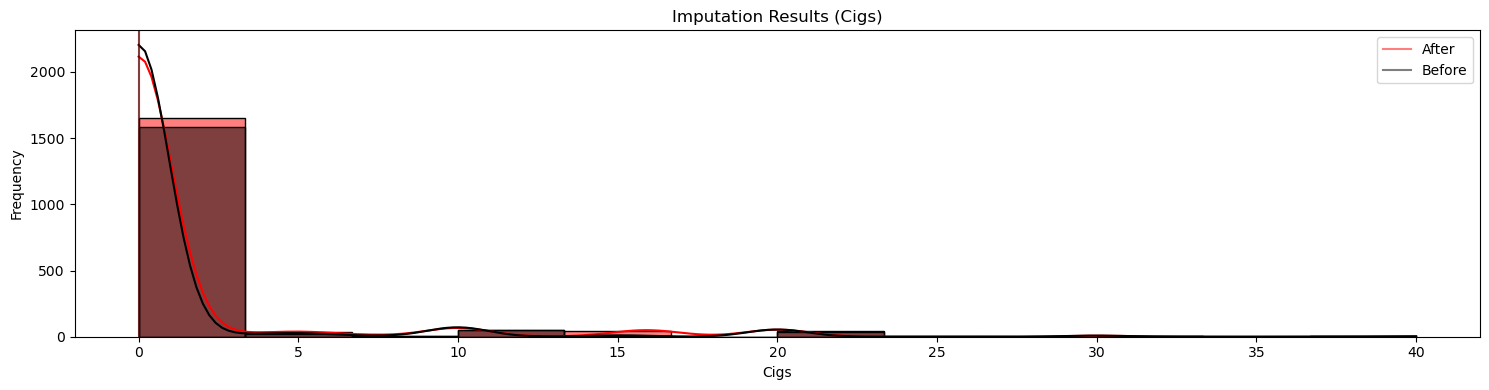

In [13]:
# Calculate medians grouped by feduc
cigs_quantile = df.groupby("feduc")["cigs"].quantile(0.95).round(0).to_dict()

# Impute missing values
df["cigs"] = df["cigs"].fillna(df["feduc"].map(cigs_quantile))

imputation_check("cigs") # user defined function to check imputation

The imputation process for missing cigarette consumption data (`cigs`) is meticulously designed, leveraging statistical quantiles- specifically, the 95th percentile of cigarette consumption by the father's educational level (`feduc`), rounded to the nearest whole number. This high quantile is deliberately chosen because unreported values often correlate with higher consumption rates, a pattern indicative of underreporting associated with undesirable behaviors. A mapping dictionary is thus created, correlating each educational level with its respective 95th percentile of consumption, to accurately impute missing values in the`cigs` feature, guided by the recorded education level in `feduc`. This approach ensures a context-sensitive restoration of data and preserves the integrity and distributional characteristics of the original dataset. The selection of this imputation method is further justified by the correlation between the father's education level and cigarette consumption, which suggests that paternal educational attainment significantly influences maternal behaviors, including smoking habits, highlighting the rationale for this nuanced imputation strategy where unreported values are typically linked to adverse outcomes.

<h4>Average Drinks per Week Consumed by the Mother (drink)</h4>

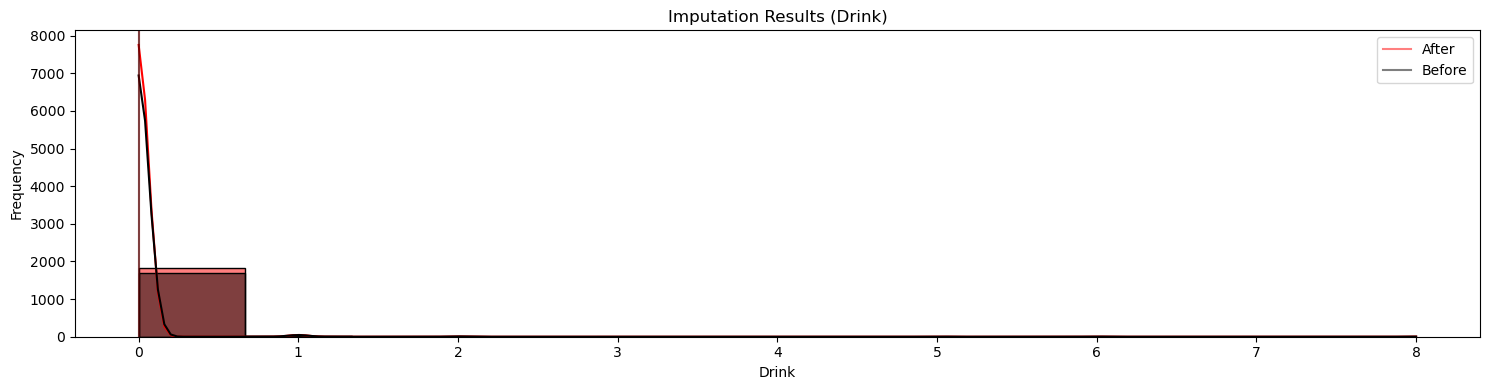

In [14]:
# Impute missing values
df["drink"] = df["drink"].fillna(df.loc[df["drink"].notnull(), "drink"].median())

imputation_check("drink") # user defined function to check imputation

The majority of mothers do not drink daily. Accordingly, the imputation strategy for the drink feature replaces missing values with the median of non-null entries (0), ensuring a balance in the dataset's distribution. By selecting the median, the method aims to minimize the impact of outliers, maintaining the dataset's statistical integrity. Following median imputation, any remaining missing values are set to 0, adopting a conservative approach. This decision, while cautious, provides a reliable benchmark for further analysis, safeguarding against distortions in data interpretation.

In [15]:
missing_values_sum = df.isna().sum()           # counting missing values
missing_values_sum[missing_values_sum > 0]     # showing missing values

bwght    184
dtype: int64

Only birthweight has missing values now. As this is the dependent variable, the imputation is concluded.

<h3>Feature Engineering</h3>

In [16]:
# prenatal visits per month since start
df["pvis_pm"] = np.where(df["monpre"] != 0,
                         df["npvis"] / df["monpre"], 0).round(decimals = 0)

# Categorizing npvis into intervals
npvis_bins = [0, 10, 15, 100]  # Define bins edges
npvis_labels = ["under_11", "11_15", "16_plus"]  # Define bin labels
df["npvis_group"] = pd.cut(df["npvis"],
                           bins   = npvis_bins,
                           labels = npvis_labels,
                           right  = True)

# Creating dummy variables for fage_group
npvis_dummies = pd.get_dummies(df["npvis_group"], prefix = "npvis").astype(int)

# Drop the original categorical age group columns
df.drop(["npvis_group"], inplace = True, axis = 1)

# Concatenating the original DataFrame with the new dummy variables
df = pd.concat([df, npvis_dummies], axis = 1)

Monthly prenatal visits, denoted as `pvis_pm`, are calculated to quantitatively evaluate the influence of heightened parental concern on prenatal care engagement. This is achieved through a conditional operation, where, for instances where the `monpre` (months before birth) feature is non-zero, the `npvis` (number of prenatal visits) is divided by `monpre`, yielding the average prenatal visits per month. In scenarios where `monpre` equals zero, indicating no prenatal months were recorded, `pvis_pm` is systematically set to 0, ensuring mathematical accuracy and the prevention of division by zero errors. Subsequently, the resultant value is refined to zero decimal places, enhancing readability and facilitating subsequent analyses. This approach underscores the analytical emphasis on discerning patterns of prenatal care utilization among highly concerned parents.

The categorization of prenatal visits into groups simplifies the analysis of how the frequency of these visits affects health outcomes. By creating specific features for each category (`npvis_under_11`, `npvis_11_15`, `npvis_16_plus`), the dataset directly reflects these distinct groups. This adjustment allows for a more transparent investigation into the role of prenatal care frequency in predicting health indicators.

In [17]:
df["educ_tot"] = df["meduc"]+df["feduc"]          # total parental education
df["hghschl_m"] = (df["meduc"] > 11).astype(int)  # high school mother
df["bchlr_m"] = (df["meduc"] > 13).astype(int)    # bachelor mother
df["mstr_m"] = (df["meduc"] > 15).astype(int)     # master mother
df["hghschl_f"] = (df["feduc"] > 11).astype(int)  # high school father
df["bchlr_f"] = (df["feduc"] > 13).astype(int)    # bachelor father
df["mstr_f"] = (df["feduc"] > 15).astype(int)     # master father

df["degrees"] = (df["hghschl_m"] + df["hghschl_f"]) * 1\
                + (df["bchlr_m"] + df["bchlr_f"]) * 2\
                + (df["mstr_m"] + df["mstr_f"]) * 3

The engineered feature `educ_tot`, created by summing `meduc` (maternal education) and `feduc` (paternal education), quantifies the combined educational attainment of both parents within the dataset. This aggregate measure posits a synergistic effect of parental education. The underlying assumption is that higher cumulative educational levels within a household correlate with improved socioeconomic status and greater health literacy. The `educ_tot` variable may also serve as an indirect marker of the child's environmental context, encompassing access to health resources, nutritional knowledge, and adopting health-promoting behaviors. It encapsulates a broad spectrum of socioeconomic factors contributing to the child's developmental milieu, potentially influencing long-term health trajectories.

The discrete classifications into categories such as `hghschl_m`, `bchlr_m`, `mstr_m` for mothers, and similarly `hghschl_f`, `bchlr_f`, `mstr_f` for fathers, further disaggregate this educational dimension, allowing for nuanced analyses of education's role on health outcomes. These binary indicators delineate whether the parents have surpassed educational thresholds corresponding to high school completion, bachelor's degree attainment, and master's degree attainment, respectively, offering a granular view of the academic landscape within the family unit. This stratification enables a more detailed exploration of the correlation between parental education levels and a spectrum of developmental indicators in offspring, underpinning the critical role of parental education in shaping health outcomes.

The `degrees` feature quantifies parental educational attainment by aggregating weighted values for high school, bachelor's, and master's degrees, reflecting the educational spectrum within a household. It assigns cumulative points for each level of education the parents complete, offering a composite score that captures the household's academic capital. This metric facilitates a nuanced exploration of the correlation between parental education and child development outcomes. Translating binary indicators into a singular measure provides a holistic assessment of the educational environment's impact on offspring. The feature underscores the significance of parental education in shaping the socioeconomic and intellectual milieu influencing child development.

In [18]:
df["age_diff"] = df["fage"]-df["mage"] # years father is older than mother

The feature `age_diff`, calculated by subtracting `mage` (maternal age) from `fage` (paternal age), quantifies the age difference between the parents within the dataset. This engineered feature can provide insights into the dynamics of parental age gaps and their potential impact on birth outcomes. Larger age differences might correlate with diverse socioeconomic and cultural backgrounds, potentially affecting prenatal care, health behaviors, and stress levels. Understanding the age disparity between parents can help identify unique challenges or advantages in parenting styles, health decision-making, and resource allocation that could indirectly influence the baby's health. Additionally, `age_diff` could be helpful in epidemiological studies examining parental age's effects on offspring's health.

In [19]:
df["cigsmage"] = df["cigs"]/df["mage"] # cigarets a day divided by mother's age

The feature `cigsmage`, created by dividing the number of cigarettes smoked per day `cigs`) by the maternal age (`mage`), represents the daily cigarette consumption relative to the mother's age. This engineered feature attempts to contextualize smoking habits within the framework of maternal age, potentially offering insights into the risk profile for adverse birth outcomes associated with smoking during pregnancy. By normalizing cigarette consumption by age, this variable might highlight how younger mothers' smoking habits differ from older mothers' and how these habits correlate with birth weight. It could suggest that younger mothers who smoke might be at a different risk level for having babies with low birth weight compared to older mothers who smoke the same amount. Additionally, `cigsmage` could serve as an indicator of the intensity of smoking exposure relative to the mother's age, which might help develop targeted interventions for mothers at various age groups.

In [20]:
# Categorizing fage into intervals
fage_bins = [18, 29, 41, 150]  # Define bins edges
fage_labels = ["under_30", "30_41", "42_plus"]  # Define bin labels
df["fage_group"] = pd.cut(df["fage"],
                          bins   = fage_bins,
                          labels = fage_labels,
                          right  = True)

# Categorizing mage into intervals
mage_bins = [15, 24, 35, 150]  # Define bins edges
mage_labels = ["under_25", "25_35", "36_plus"]  # Define bin labels
df["mage_group"] = pd.cut(x      = df["mage"],
                          bins   = mage_bins,
                          labels = mage_labels,
                          right  = True)

# Creating dummy variables for fage_group
fage_dummies = pd.get_dummies(df["fage_group"], prefix = "fage").astype(int)

# Creating dummy variables for mage_group
mage_dummies = pd.get_dummies(df["mage_group"], prefix = "mage").astype(int)

# Drop the original categorical age group columns
df.drop(["fage_group", "mage_group"], inplace = True, axis = 1)

# Concatenating the original DataFrame with the new dummy variables
df = pd.concat([df, fage_dummies, mage_dummies], axis = 1)

This feature engineering approach transforms the continuous variables `fage` (father's age) and `mage` (mother's age) into categorical variables, categorizing them into distinct age groups. Further, they are processed into dummy variables. By segmenting ages into predefined bins, this method allows for the analysis of birth outcomes across different parental age groups, potentially uncovering age-related patterns or risk factors. Converting these categories into dummy variables (one-hot encoding) can improve model interpretability and allow for capturing non-linear relationships between parental age and birth outcomes. Dropping the created categorical age groups keeps the dataset tidy and focused on the newly engineered features.

<h3>Exploring the Determinants of Neonatal Birthweight</h3>

In [21]:
# Calculate Pearson correlations for numerical columns
corr_bwght = df.select_dtypes(include = [np.number]) \
    .corr(method = "pearson").round(4) \
    .drop("bwght", axis = 0) \
    .loc[:, ["bwght"]] \
    .query("abs(bwght) > 0.0") \
    .sort_values(by = "bwght", ascending = False) # round, filter, and sort

corr_bwght.T # Display the relevant, ordered correlations (transposed)

,npvis,npvis_11_15,mage_25_35,fage,male,fwhte,degrees,age_diff,mstr_f,fage_30_41,mwhte,bchlr_m,mstr_m,pvis_pm,educ_tot,bchlr_f,feduc,npvis_16_plus,hghschl_f,meduc,mage,fage_42_plus,m_fage,hghschl_m,m_npvis,monpre,m_feduc,m_meduc,m_monpre,drink,fblck,mage_36_plus,mblck,m_drink,m_cigs,moth,fage_under_30,foth,mage_under_25,cigs,cigsmage,npvis_under_11
bwght,0.1009,0.0907,0.0839,0.0721,0.0663,0.0657,0.0624,0.0601,0.059,0.0568,0.0546,0.0522,0.0514,0.0415,0.0406,0.0386,0.037,0.0366,0.0362,0.036,0.0341,0.029,0.026,0.0004,-0.0007,-0.0019,-0.0026,-0.0041,-0.01,-0.0188,-0.0202,-0.021,-0.0222,-0.0466,-0.0532,-0.0535,-0.071,-0.0714,-0.0857,-0.0878,-0.0959,-0.1154


Based on the provided correlation coefficients between birthweight (`bwght`) and various predictors, it is evident that there are no firm linear (Pearson) correlations with birthweight in the dataset, as all the provided coefficients lie within a relatively narrow range, with none approaching the extreme values of -1 or 1 that would indicate perfect linear relationships. However, several noteworthy moderate correlations merit attention. 

Starting with the positive correlations, the highest observed is the number of prenatal visits (`npvis`), with a correlation coefficient of 0.1009, suggesting a slight positive linear relationship between prenatal care and birthweight, which implies that increased prenatal care, indicative of better maternal health monitoring, might be associated with healthier birth outcomes. Other variables showing positive correlations, though modest, include average prenatal visits (`npvis_11_15`), usual mother age (`mage_25_35`), paternal age (`fage`), the baby's gender being male (`male`), and whether the father is white (`fwhte`). Also to be noted are the correlations with weigthed degrees (`degrees`), the highest level of education of a mother (`mstr_f`) and the age difference between father and mother (`age_diff`), indicating that smart mothers tend to have slightly healthier babies. Although not strong, these positive correlations hint at demographic and biological factors that significantly influence increasing birth weight.

On the negative side, the strongest correlations are observed with a low number of prenatal visits (`npvis_under_11`), which makes sense considering that less visits decrease the ability to detect problems within pregnancy. Second are maternal smoking habits (`cigs` and `cigsmage`), both showing notable negative correlations with birthweight. Smoking during pregnancy is a risk factor for lower birthweight, with `cigsmage` particularly highlighting the intensified negative impact when considering the mother's age. Other variables such as being of other races (`moth`,`foth`), and the age groups `fage_under_30` and `mage_under_25` also show negative correlations, suggesting these groups are associated with lower birthweights, potentially due to socio-economic factors or biological risks associated with younger parental age.

In summary, while there are no strong linear correlations with birthweight, the observed moderate correlations offer valuable insights. The positive relationships with prenatal visits and specific demographic characteristics underscore the importance of healthcare access and parental factors in birth outcomes. Conversely, the negative correlations between maternal smoking and certain age and racial groups highlight risk factors that can detrimentally affect birth weight. These findings underscore the complex interplay of genetic, environmental, and behavioral factors in determining birth weight, with implications for targeted public health strategies and interventions.

<h3>Dependent Variable Boolean Transformation</h3>

Number of babies with low birthweight: 84
Percentage of babies with low birthweight: 4.59%


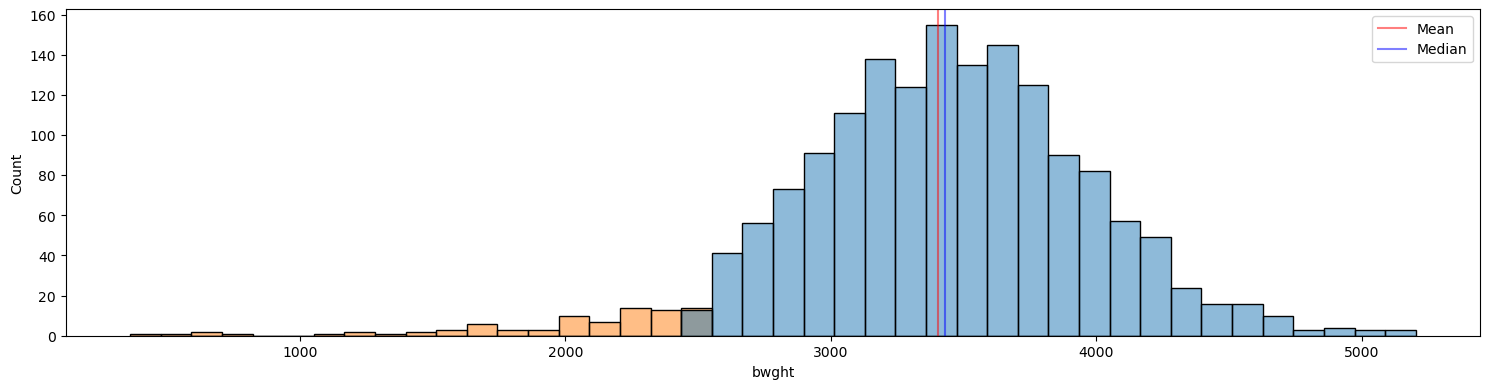

In [22]:
# Dummy encoding "low birthweight or not" using vectorized operation
df["low_bwght"] = (df["bwght"] < 2500).astype(int)  # 2500 g = WHO threshold

# Calculate the number of babies with low birthweight
num_low_bwght = df["low_bwght"].sum()

# Calculate the percentage of babies with low birthweight
percentage_low_bwght = (num_low_bwght / df.shape[0] * 100).round(2)

# Print the results
print(f"Number of babies with low birthweight: {num_low_bwght}")
print(f"Percentage of babies with low birthweight: {percentage_low_bwght}%")

histplot(feature = "bwght", hue = "low_bwght", df = df) # showing birthweight

Incorporating the engineered feature `low_bwght` as the dependent variable transforms the analysis into a classification problem, where the objective is to predict whether a newborn will have a low birthweight (less than 2500 grams - highlighted in orange above) based on various predictors. This <a href="https://www.who.int/data/nutrition/nlis/info/low-birth-weight" target="_blank">binary indicator</a>, derived from the World Health Organization's low birthweight threshold, is pivotal in identifying infants at an increased risk for adverse health outcomes, making it an essential metric for clinical and public health interventions. Converting the continuous birthweight data into a categorical outcome facilitates the application of classification algorithms, aiming to uncover the most significant predictors of low birthweight. This approach not only streamlines the modeling process by clearly defining the prediction target but also aligns with healthcare priorities by focusing on a key indicator of neonatal health. As the dependent variable, low_bwght will guide the selection and evaluation of features included in the predictive model, emphasizing the importance of accurately identifying at-risk infants for early intervention strategies.

In [23]:
df.head(n = 2) # checking on all features for new correlations

,mage,meduc,monpre,npvis,fage,feduc,cigs,drink,male,mwhte,mblck,moth,fwhte,fblck,foth,bwght,set,m_meduc,m_monpre,m_npvis,m_fage,m_feduc,m_cigs,m_drink,pvis_pm,npvis_under_11,npvis_11_15,npvis_16_plus,educ_tot,hghschl_m,bchlr_m,mstr_m,hghschl_f,bchlr_f,mstr_f,degrees,age_diff,cigsmage,fage_under_30,fage_30_41,fage_42_plus,mage_under_25,mage_25_35,mage_36_plus,low_bwght
obs_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
id_0001,33,12.0,1.0,5.0,31.0,11.0,0.0,0.0,1,1,0,0,1,0,0,360.0,Not Kaggle,0,0,0,0,0,0,0,5.0,1,0,0,23.0,1,0,0,0,0,0,1,-2.0,0.0,0,1,0,0,1,0,1
id_0002,30,14.0,2.0,6.0,31.0,14.0,0.0,0.0,0,1,0,0,1,0,0,506.0,Not Kaggle,0,0,0,0,0,0,0,3.0,1,0,0,28.0,1,1,0,1,1,0,6,1.0,0.0,0,1,0,0,1,0,1


In [24]:
# creating feature sets for correlations
semi_continuous = ["mage", "meduc", "monpre", "npvis", "fage", "feduc", "cigs",
                  "drink", "pvis_pm", "educ_tot", "degrees", "age_diff",
                   "cigsmage", "low_bwght"]

non_continuous = ["male", "mwhte", "mblck", "moth", "fwhte", "fblck",
                  "foth", "m_meduc", "m_monpre", "m_npvis", "m_fage",
                  "m_feduc", "m_cigs", "m_drink",
                  "pvis_pm", "npvis_under_11", "npvis_11_15", "npvis_16_plus",
                  "hghschl_m", "bchlr_m", "mstr_m", "hghschl_f", "bchlr_f",
                  "mstr_f", "fage_under_30", "fage_30_41", "fage_42_plus",
                  "mage_under_25", "mage_25_35", "mage_36_plus", "low_bwght"]

In [25]:
# Calculate Point-Biserial Correlations
corr_pb_low_bwght = df[semi_continuous]\
    .corr(method = "pearson").round(4) \
    .drop(["low_bwght"], axis = 0) \
    .loc[:, ["low_bwght"]] \
    .query("abs(low_bwght) > 0.04") \
    .sort_values(by = "low_bwght", ascending = False) # round, filter, and sort

corr_pb_low_bwght.T # Display the relevant, ordered correlations (transposed)

,cigsmage,cigs,fage,npvis
low_bwght,0.0564,0.0469,-0.0406,-0.0578


After transforming birthweight (`bwght`) into a binary variable (`low_bwght`) to indicate low birthweight, the point-biserial correlation coefficients generally appear lower in magnitude compared to correlations with the original, continuous form of birthweight. This change suggests that when considered as a continuous variable, the linear relationship between each predictor and birthweight does not directly translate into a similarly strong relationship when birthweight is categorized into a binary outcome. The reduction in correlation magnitudes prompts the examination of phi coefficients, a measure suited explicitly for binary variables in classification modeling, to understand better the strength and direction of associations within this transformed context.

In [26]:
# Calculate Phi Coefficients
corr_ph_low_bwght = df[non_continuous].astype("category")\
    .phik_matrix().round(4) \
    .drop(["low_bwght"], axis = 0) \
    .loc[:, ["low_bwght"]] \
    .query("abs(low_bwght) > 0.04") \
    .sort_values(by = "low_bwght", ascending = False) # round, filter, and sort

corr_ph_low_bwght.T # Display the relevant, ordered coefficients (transposed)

,npvis_under_11,mage_25_35,npvis_11_15,mage_under_25,m_cigs
low_bwght,0.1027,0.0964,0.0855,0.0672,0.047


After transforming birthweight (`bwght`) into a binary variable (`low_bwght`), indicating low birthweight, the nature of correlations shifted, as observed in the differences between the original Pearson correlation coefficients and the point-biserial and phi coefficients. Initially, continuous variables like `npvis` and `cigsmage` showed moderate linear relationships with birthweight, suggesting that as these factors increase or decrease, so does the birthweight in a continuous manner. However, when birthweight was categorized, the magnitudes of the correlations generally decreased. The same is the case with phi-coefficients `npvis_under_11`, `npvis_11_15`, `m_cigs`, and `mage_under_25`. Notably though, the phi-coefficient for `mage_25_35`improved slightly.

This decrease in correlation magnitudes after categorization indicates that the strength of linear relationships is diluted when the outcome variable is binary. The phi coefficients, suitable for analyzing relationships involving two binary variables, show different relationships, emphasizing different aspects of the data that are more pronounced in a binary context. This transformation to a binary outcome changes the nature of the measured relationship, from linear trends across a spectrum of birthweights to a more nuanced association that captures the low vs. not low birthweight dichotomy. Consequently, while some relationships may seem less strong or direct, the binary categorization reveals new dynamics that were less apparent or relevant in the continuous analysis, underscoring the complexity of factors influencing low birthweight.

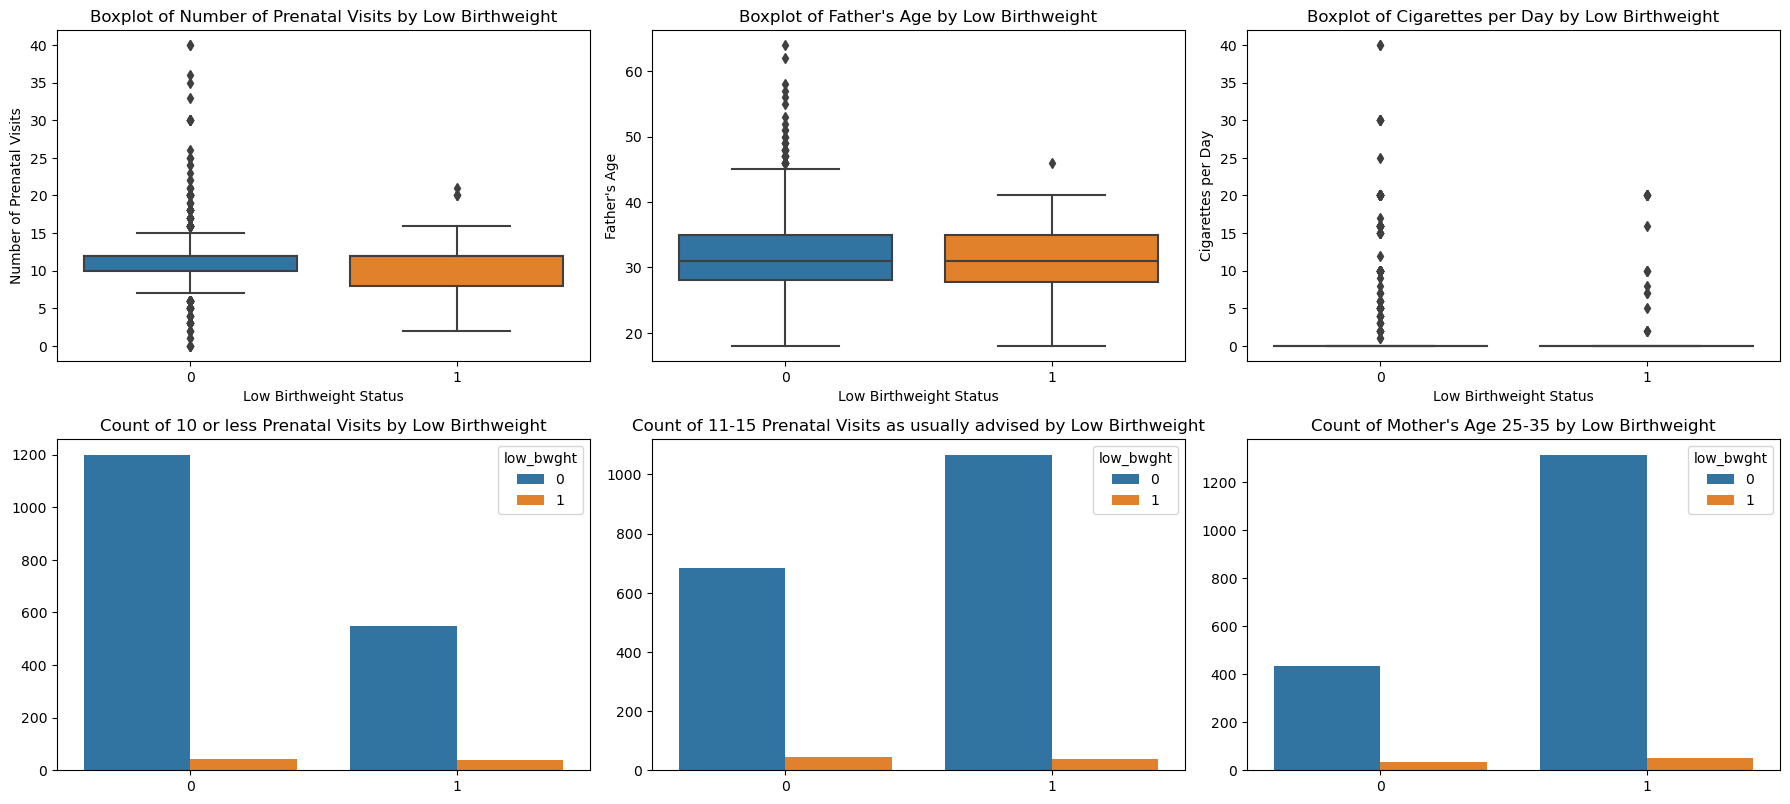

In [27]:
# Set up the matplotlib figure
plt.figure(figsize=(18, 12))

target = "low_bwght" # selecting target feature

# Mapping for more intuitive feature names
features_continuous_pretty = {
    "npvis": "Number of Prenatal Visits",
    "fage": "Father's Age",
    "cigs": "Cigarettes per Day"} # continuous data

features_categorical_pretty = {
    "npvis_under_11": "10 or less Prenatal Visits",
    "npvis_11_15": "11-15 Prenatal Visits as usually advised",
    "mage_25_35": "Mother's Age 25-35"} # categorical data

# Plotting for continuous features with proper labels and titles
for i, feature in enumerate(features_continuous_pretty, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x = target, y = feature, data = df)
    plt.title(f"Boxplot of {features_continuous_pretty[feature]} by Low Birthweight")
    plt.xlabel("Low Birthweight Status")
    plt.ylabel(features_continuous_pretty[feature])

# Plotting for categorical features with proper labels and titles
for i, feature in enumerate(features_categorical_pretty, 4): # continuing at 4
    plt.subplot(3, 3, i)
    sns.countplot(x = feature, hue = target, data = df)
    plt.title(f"Count of {features_categorical_pretty[feature]} by Low Birthweight")
    plt.xlabel("")
    plt.ylabel("")

plt.tight_layout()  # Adjust layout for better readability
plt.show()  # Show the plots

The visualizations generated provide a comprehensive analysis of the relationships between various predictors and the incidence of low birthweight in newborns. The boxplots for continuous variables—number of prenatal visits (`npvis`), father's age (`fage`), and cigarettes smoked per day (`cigs`)—contrast the distributions between normal and low birthweight groups. The boxplots show that the median number of prenatal visits appears slightly higher for the normal birthweight group than the low birthweight group, suggesting a potential protective effect of prenatal care. The age of fathers seems to have a wider distribution for babies with normal birth weight. In contrast, smoking behavior shows a higher median but less extreme values for the low birthweight group, implying a negative impact of smoking on birthweight.

Count plots for categorical variables, including maternal age category 25-35`mage_25_35`) and a binary variable indicating prenatal visits (`npvis_under_11`, `npvis_11_15`), reveal notable disparities. For instance, there is a higher prevalence of mothers in the perfect age (`mage_25_35`) in the low birthweight category, which might indicate that mothers within the age group of 25-35 are associated with an increased risk of low birth weight.

These findings also highlight the importance of targeted interventions to promote prenatal care and smoking cessation, especially among populations identified as at-risk through these visual analyses.

In [28]:
df.describe(include = "number").round(decimals = 2)

,mage,meduc,monpre,npvis,fage,feduc,cigs,drink,male,mwhte,mblck,moth,fwhte,fblck,foth,bwght,m_meduc,m_monpre,m_npvis,m_fage,m_feduc,m_cigs,m_drink,pvis_pm,npvis_under_11,npvis_11_15,npvis_16_plus,educ_tot,hghschl_m,bchlr_m,mstr_m,hghschl_f,bchlr_f,mstr_f,degrees,age_diff,cigsmage,fage_under_30,fage_30_41,fage_42_plus,mage_under_25,mage_25_35,mage_36_plus,low_bwght
count,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1648.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00,1832.00
mean,29.56,13.49,2.12,11.62,31.92,13.56,1.38,0.02,0.51,0.89,0.06,0.05,0.89,0.06,0.05,3405.56,0.02,0.00,0.04,0.00,0.03,0.06,0.06,7.28,0.32,0.60,0.07,27.05,0.93,0.49,0.34,0.91,0.54,0.41,6.15,2.36,0.05,0.33,0.61,0.05,0.14,0.74,0.11,0.05
std,4.77,2.71,1.23,3.62,5.71,3.14,4.61,0.28,0.50,0.32,0.24,0.23,0.31,0.23,0.22,576.12,0.13,0.05,0.19,0.06,0.16,0.24,0.24,4.37,0.47,0.49,0.26,5.27,0.25,0.50,0.47,0.28,0.50,0.49,4.18,4.15,0.17,0.47,0.49,0.22,0.35,0.44,0.32,0.21
min,16.00,0.00,0.00,0.00,18.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,360.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-15.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,26.00,12.00,1.00,10.00,28.00,12.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,3080.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,0.00,0.00,24.00,1.00,0.00,0.00,1.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,29.00,13.00,2.00,12.00,31.00,14.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,3430.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.00,0.00,1.00,0.00,28.00,1.00,0.00,0.00,1.00,1.00,0.00,6.00,2.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
75%,33.00,16.00,2.00,12.00,35.00,16.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,3770.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00,1.00,1.00,0.00,32.00,1.00,1.00,1.00,1.00,1.00,1.00,12.00,4.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00
max,44.00,17.00,9.00,40.00,64.00,17.00,40.00,8.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,5204.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,36.00,1.00,1.00,1.00,34.00,1.00,1.00,1.00,1.00,1.00,1.00,12.00,27.00,1.30,1.00,1.00,1.00,1.00,1.00,1.00,1.00


The average maternal age in the dataset is 29.56 years, indicating a predominance of births to women in their late twenties and early thirties. Both parents exhibit a similar level of education on average, with maternal education (meduc) at 13.49 years and paternal education (feduc) at 13.56 years, suggesting a high level of secondary education completion among parents. On average, women had 11.62 prenatal visits, reflecting adherence to recommended prenatal care guidelines. The average number of cigarettes smoked per day by mothers during pregnancy is 1.38, and the average alcohol consumption is 0.02 drinks per day, indicating low levels of substance use among the cohort. The dataset shows a slightly higher number of male births (51%) than female births. The distribution of racial demographics for both mothers and fathers is heavily skewed towards whites, with 89% for both groups, highlighting a lack of racial diversity in the sample. The mean birth weight is 3,405 grams, which is considered perfectly normal. High school completion rates for mothers and fathers are high, with 93% and 91%, respectively, indicating a generally well-educated sample population. Bachelor's and master's degree attainment among parents suggests a significant proportion of the sample has higher education, with 49% of mothers and 54% of fathers having a bachelor's degree and 34% of mothers and 41% of fathers having a master's degree.

<h3>Yeo-Johnson Transformation</h3>

In [29]:
# subsetting X-data
x_data = df.drop(["bwght", "low_bwght", "set"], axis = 1)

# yeo-johnson transformation
x_transformed = power_transform(X           = x_data,
                                method      = "yeo-johnson",
                                standardize = True        )

# storing results as a DataFrame
x_transformed_df = pd.DataFrame(data    = x_transformed,
                                columns = list(x_data.columns))

<h3>Restandardization</h3>

In [30]:
scaler = StandardScaler(copy  = True)         # Instantiating a scaler object
scaler.fit(x_transformed_df)                  # Fitting scaler with the data
x_scaled = scaler.transform(x_transformed_df) # Transforming data after fit

# converting into a DataFrame, reattaching feature names, and setting index
x_data_st = pd.DataFrame(data = x_scaled,     
                         columns = list(x_transformed_df.columns),
                         index = df.index)

In [31]:
# preparing DataFrame for modeling
df_prep = pd.concat(objs = [df[["low_bwght", "set"]], x_data_st],
                    axis = 1,
                    ignore_index = False) # integrating transformed x data

# dropping features that result in colinearity problems
df_prep.drop(["drink", "moth", "foth", "m_monpre", "m_npvis", "npvis_16_plus",
              "hghschl_m", "hghschl_f", "fage_30_41", "mage_25_35"],
             inplace = True, axis = 1)

<h2>Part III: Data Partitioning</h2>
<h3>Separating the Kaggle Data</h3><br>
The dataset is divided into modeling and prediction data and the set identifier is dropped.

In [32]:
# parsing out testing data
kaggle_data = df_prep[ df_prep["set"] == "Kaggle" ].copy()     # kaggle df
model_data  = df_prep[ df_prep["set"] == "Not Kaggle" ].copy() # model df
kaggle_data.drop(labels = "set", axis = 1, inplace = True) # dropping kaggle identifier
model_data.drop(labels = "set", axis = 1, inplace = True)  # dropping model building identifier

In [33]:
# prepping data for train-test split
y_data = model_data["low_bwght"]
x_data = model_data.drop("low_bwght", axis = 1)

<h3>Train-Test Split</h3>

In [34]:
# train-test split (to validate the model)
x_train, x_test, y_train, y_test = train_test_split(
    x_data,                # defined above
    y_data,                # defined above
    test_size    = 0.25,   # sample split size
    random_state = 1836,   # ensures reproducability
    stratify     = y_data) # preserving balance in dependent variable

# merging training data for statsmodels
model_train = pd.concat([x_train, y_train], axis = 1)

# results of train-test split
print(f"""
Dimensions
----------
Target Feature:                {y_train.name}
Independent Features:          {x_data.shape[1]}

Original Dataset Observations: {df.shape[0]}
Training Data Observations:    {x_train.shape[0]}
Testing Data Observations:     {x_test.shape[0]}

Response Variable Proportions (Training Set)
--------------------------------------------
{y_train.value_counts(normalize = True).round(decimals = 2)}

Response Variable Proportions (Testing Set)
--------------------------------------------
{y_test.value_counts(normalize = True).round(decimals = 2)}
""")


Dimensions
----------
Target Feature:                low_bwght
Independent Features:          32

Original Dataset Observations: 1832
Training Data Observations:    1236
Testing Data Observations:     412

Response Variable Proportions (Training Set)
--------------------------------------------
low_bwght
0    0.95
1    0.05
Name: proportion, dtype: float64

Response Variable Proportions (Testing Set)
--------------------------------------------
low_bwght
0    0.95
1    0.05
Name: proportion, dtype: float64



<h3>Fit Model</h3><br>
A logit classification model was initially constructed using all available features from the model dataset. A meticulous iterative refinement process pruned features with p-values above the 20%, 15%, 10%, and 5% significance threshold respectively, ensuring final fit models only included variables with statistically significant contributions.

In [35]:
# instantiating a logistic regression model object with p < 20%
logistic_fit = smf.logit(
    formula = """low_bwght ~
monpre
+ feduc
+ cigs
+ mwhte
+ m_cigs
+ m_drink
+ npvis_under_11
+ degrees
+ cigsmage
+ fage_42_plus
+ mage_under_25
+ mage_36_plus
""",
    data    = model_train)

results_logistic = logistic_fit.fit()          # fitting the model object
results_logistic.summary2() # checking the results summary with AIC and BIC

Optimization terminated successfully.
         Current function value: 0.188212
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Method:           MLE      
Dependent Variable: low_bwght        Pseudo R-squared: 0.065    
Date:               2024-03-10 01:36 AIC:              491.2598 
No. Observations:   1236             BIC:              557.8151 
Df Model:           12               Log-Likelihood:   -232.63  
Df Residuals:       1223             LL-Null:          -248.89  
Converged:          1.0000           LLR p-value:      0.0011530
No. Iterations:     8.0000           Scale:            1.0000   
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
Intercept       -3.1669   0.1597 -19.8349 0.0000 -3.4798 -2.8539
monpre          -0.2252   0.1384  -1.6275 0.1036 -0.4965  0.0460
feduc           -0.4079   0.2500  -1.6318 0.1027 -0.8979  0.0820
cigs             2.3942   1.5343   1.5605 0.1186 -0.6129  5.4013
mwhte            0.2340   0.1689   1.3854 0.1659 -0.0971  0.5651
m_cigs           0.5058   0.2869   1.7630 0.0779 -0.0565  1.0681
m_drink         -0.4544   0.3029  -1.5002 0.1336 -1.0481  0.1393
npvis_under_11   0.4044   0.1366   2.9594 0.0031  0.1366  0.6722
degrees          0.4082   0.2631   1.5514 0.1208 -0.1075  0.9240
cigsmage        -2.2663   1.5499  -1.4622 0.1437 -5.3041  0.7715
fage_42_plus    -0.4700   0.2745  -1.7120 0.0869 -1.0080  0.0681
mage_under_25    0.2295   0.1270   1.8074 0.0707 -0.0194  0.4783
mage_36_plus     0.3476   0.1206   2.8816 0.0040  0.1112  0.5840
================================================================

"""

In [36]:
# instantiating a logistic regression model object with p < 15%
logistic_fit = smf.logit(
    formula = """low_bwght ~
monpre
+ feduc
+ cigs
+ m_cigs
+ m_drink
+ npvis_under_11
+ degrees
+ cigsmage
+ fage_42_plus
+ mage_under_25
+ mage_36_plus
""",
    data    = model_train)

results_logistic = logistic_fit.fit()          # fitting the model object
results_logistic.summary2() # checking the results summary with AIC and BIC

Optimization terminated successfully.
         Current function value: 0.189152
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Method:           MLE      
Dependent Variable: low_bwght        Pseudo R-squared: 0.061    
Date:               2024-03-10 01:36 AIC:              491.5830 
No. Observations:   1236             BIC:              553.0187 
Df Model:           11               Log-Likelihood:   -233.79  
Df Residuals:       1224             LL-Null:          -248.89  
Converged:          1.0000           LLR p-value:      0.0014799
No. Iterations:     8.0000           Scale:            1.0000   
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
Intercept       -3.1459   0.1565 -20.0981 0.0000 -3.4527 -2.8391
monpre          -0.2235   0.1367  -1.6351 0.1020 -0.4914  0.0444
feduc           -0.4060   0.2483  -1.6353 0.1020 -0.8926  0.0806
cigs             2.3456   1.5237   1.5394 0.1237 -0.6408  5.3321
m_cigs           0.5119   0.2883   1.7756 0.0758 -0.0532  1.0770
m_drink         -0.4585   0.3045  -1.5058 0.1321 -1.0554  0.1383
npvis_under_11   0.4045   0.1360   2.9745 0.0029  0.1379  0.6710
degrees          0.3880   0.2625   1.4782 0.1394 -0.1264  0.9024
cigsmage        -2.2174   1.5401  -1.4398 0.1499 -5.2359  0.8011
fage_42_plus    -0.4610   0.2694  -1.7110 0.0871 -0.9891  0.0671
mage_under_25    0.2139   0.1267   1.6885 0.0913 -0.0344  0.4621
mage_36_plus     0.3458   0.1201   2.8788 0.0040  0.1104  0.5813
================================================================

"""

In [37]:
# instantiating a logistic regression model object with p < 10%
logistic_fit = smf.logit(
    formula = """low_bwght ~
monpre
+ npvis_under_11
+ mage_under_25
+ mage_36_plus
""",
    data    = model_train)

results_logistic = logistic_fit.fit()          # fitting the model object
results_logistic.summary2() # checking the results summary with AIC and BIC

Optimization terminated successfully.
         Current function value: 0.194539
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Method:           MLE      
Dependent Variable: low_bwght        Pseudo R-squared: 0.034    
Date:               2024-03-10 01:36 AIC:              490.9013 
No. Observations:   1236             BIC:              516.4995 
Df Model:           4                Log-Likelihood:   -240.45  
Df Residuals:       1231             LL-Null:          -248.89  
Converged:          1.0000           LLR p-value:      0.0020481
No. Iterations:     7.0000           Scale:            1.0000   
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
Intercept       -3.0469   0.1435 -21.2360 0.0000 -3.3281 -2.7657
monpre          -0.2630   0.1361  -1.9332 0.0532 -0.5297  0.0036
npvis_under_11   0.4336   0.1343   3.2278 0.0012  0.1703  0.6970
mage_under_25    0.2003   0.1179   1.6992 0.0893 -0.0307  0.4314
mage_36_plus     0.2656   0.1143   2.3241 0.0201  0.0416  0.4897
================================================================

"""

In [38]:
# instantiating a logistic regression model object with p < 5%
logistic_fit = smf.logit(
    formula = """low_bwght ~
npvis_under_11
+ mage_36_plus
""",
    data    = model_train)

results_logistic = logistic_fit.fit()          # fitting the model object
results_logistic.summary2() # checking the results summary with AIC and BIC

Optimization terminated successfully.
         Current function value: 0.196849
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Method:           MLE      
Dependent Variable: low_bwght        Pseudo R-squared: 0.022    
Date:               2024-03-10 01:36 AIC:              492.6096 
No. Observations:   1236             BIC:              507.9685 
Df Model:           2                Log-Likelihood:   -243.30  
Df Residuals:       1233             LL-Null:          -248.89  
Converged:          1.0000           LLR p-value:      0.0037682
No. Iterations:     7.0000           Scale:            1.0000   
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
Intercept       -3.0052   0.1388 -21.6525 0.0000 -3.2773 -2.7332
npvis_under_11   0.3520   0.1227   2.8675 0.0041  0.1114  0.5926
mage_36_plus     0.2442   0.1113   2.1929 0.0283  0.0259  0.4624
================================================================

"""

These streamlined models, which retain only the most impactful predictors, are saved below:

In [39]:
candidate_dict = { # creating a dictionary to store candidate models
 # full model
 "full" : ["mage", "meduc", "monpre", "npvis", "fage", "feduc", "cigs", 
           "male", "mwhte", "mblck", "fwhte", "fblck", "m_meduc", "m_fage",
           "m_feduc", "m_cigs", "m_drink", "pvis_pm", "npvis_under_11",
           "npvis_11_15", "educ_tot", "bchlr_m", "mstr_m", "bchlr_f",
           "mstr_f", "degrees", "age_diff", "cigsmage", "fage_under_30",
           "fage_42_plus", "mage_under_25", "mage_36_plus"],
 
 # p-value significant variables (to 20%) only
 "fit_20": ["monpre", "feduc", "cigs", "mwhte", "m_cigs", "m_drink",
            "npvis_under_11", "degrees", "cigsmage", "fage_42_plus",
            "mage_under_25", "mage_36_plus"] ,
    
 # p-value significant variables (to 15%) only
 "fit_15": ["monpre", "feduc", "cigs", "m_cigs", "m_drink",
            "npvis_under_11", "degrees", "cigsmage", "fage_42_plus",
            "mage_under_25", "mage_36_plus"],
    
 # p-value significant variables (to 10%) only
 "fit_10": ["monpre", "npvis_under_11", "mage_under_25", "mage_36_plus"], 
   
 # p-value significant variables (to 5%) only
 "fit_5": ["npvis_under_11", "mage_36_plus"],     

 # coefficients above 0.5 in logistic regression
 "coeff_high": ["monpre", "cigs", "m_cigs", "m_drink", "pvis_pm", "cigsmage"]}

In the feature selection process for a logistic regression model, an iterative approach was employed to isolate features exhibiting coefficients with an absolute value greater than 0.5. Initially, the model incorporated the complete set of explanatory variables. Subsequent iterations involved systematically excluding the feature with the lowest absolute coefficient value. This iterative exclusion continued until the remaining features each had a coefficient absolute value exceeding the threshold of 0.5. At every iteration, hyperparameter tuning of the logistic regression model was conducted to optimize its performance. This meticulous procedure ensured that the final set of features, which demonstrated significant predictive power as evidenced by their coefficients' magnitude, was identified and presented.

<h2>Part IV: Candidate Modeling</h2><br>
Before candidate models are developed, functions are created to facilitate this process.

In [40]:
# creating a modeling function
def model(x_features,                   # independent variable dictionary
          y_feature,                    # dependent variable
          model,                        # model to be used
          name,                         # name to identify model better
          thresh             = None,    # threshold to change predictions to 1
          thresh_results     = False,   # printing value counts of probs
          coeff              = False,   # printing coefficients
          tree               = False,   # printing deciscion tree plot
          feature_importance = False,   # printing feature importance plot
          cm                 = False,): # printing confusion matrix
    """
    Executes specified regression model on training data, evaluates its
    performance, and optionally generates various outputs.

    Parameters:
    - x_features: str
        Independent variables dictionary to specify data to be used.
    - y_feature: str
        Dependent variable to specify data to be used.
    - model: estimator object (regression model to use)
        This should be a scikit-learn-like model that
        has .fit(), .predict(), and .score() methods.
    - name: str
        Name of the regression model for identification in outputs.
    - thresh: float, optional (default = None)
        Threshold to change predictions to 1.
    - thresh_results: bool, optional (default = False)
        If True, prints propabilities of low_bwght.
    - coeff: bool, optional (default = False)
        If True, prints the model's coefficients.
        Not applicable for models without .coef_ attribute.
    - tree: bool, optional (default = False)
        If True, plots the decision tree.
        Only applicable for decision tree models.
    - feature_importance: bool, optional (default = False)
        If True, plots the importance of features.
        Applicable for models with .feature_importances_ attribute.
    - cm: bool, optional (default = False)
        If True, print confusion matrix.

    Outputs:
    - Print statements summarizing the model's performance, including
      training and testing scores, and the gap between these scores.
    - Optionally, outputs plots for residuals, decision tree visualization,
      and feature importance based on the parameters provided.
    - Stores the model's predictions on a provided Kaggle dataset to a CSV
      file for submission.

    Requires:
    - Variables x_train, y_train, x_test, y_test, x_data, model_results, and
      kaggle_data must be predefined in the global calling environment.
    - The pandas, numpy, matplotlib.pyplot, and seaborn libraries for
      data manipulation and plotting.

    Note:
    - This function assumes that the training and testing datasets
      (x_train, x_test, y_train, y_test), as well as feature names in x_data,
      are predefined and available in the calling environment.
    - The function updates the global model_results DataFrame with the
      current model's results and saves the predictions for the Kaggle
      competition to a file in the "./outputs" directory.
    - Designed to be flexible but expects a scikit-learn-compatible model.
    """
    global model_results, model_data, kaggle_data
    
    # selecting data
    x_data = model_data[candidate_dict[x_features]]
    y_data = model_data[y_feature]
    
    # train-test split (to validate the model)
    x_train, x_test, y_train, y_test = train_test_split(
        x_data,                # as selected
        y_data,                # as selected
        test_size    = 0.25,   # sample split size
        random_state = 1836,   # ensures reproducability
        stratify     = y_data) # preserving balance in dependent variable
    
    ## Applying Model ########################################################        
    model_fit = model.fit(x_train, y_train)         # fitting training data
    model_pred = model.predict(x_test)              # predicting data

    if thresh is not None:
        # Get the predicted probabilities for the positive class
        model_pred_proba = model.predict_proba(x_test)[:, 1]
        
        # Apply threshold to determine class labels
        model_pred = (model_pred_proba >= thresh).astype(int)
        
    # scoring results
    model_train_score = model.score(x_train, y_train).round(decimals = 4)
    model_test_score  = model.score(x_test, y_test).round(decimals = 4)
    model_gap         = abs(model_train_score - model_test_score).round(decimals = 4)
    
    # confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true = y_test,
                                      y_pred = model_pred).ravel()
    
    # preparing AUC, precision, and recall
    auc            = roc_auc_score(y_true   = y_test,     # auc
                                   y_score  = model_pred).round(decimals = 4)
    accuracy       = accuracy_score(y_true  = y_test,     # accuracy
                                    y_pred  = model_pred).round(decimals = 4)
    precision      = precision_score(y_true = y_test,     # precision
                                     y_pred = model_pred).round(decimals = 4)
    recall         = recall_score(y_true    = y_test,     # sensitivity
                                  y_pred    = model_pred).round(decimals = 4)
    specificity    = (tn / (tn + fp)).round(decimals = 4) # specificity


    # dynamically printing model summary and metrics
    thresh_display = thresh if thresh is not None else 0.5
    print(f"""\
    Model Name:     {name} with {x_features} and threshold {thresh_display}
    Train Score:    {model_train_score}
    Test Score:     {model_test_score}
    Train-Test Gap: {model_gap}
    
    AUC:                              {auc}
    Accuracy ((TP+TN)/(TP+TN+FP+FN)): {accuracy}
    Precision (TP/(TP+FP)):           {precision}
    Recall/Sensitivity (TP/(TP+FN)):  {recall}
    Specificity (TN/(TN+FP)):         {specificity}""")  
    
    ## Coefficients ##########################################################    
    if coeff == True: # printing coefficients
        # zipping each feature name to its coefficient
        model_coefficients = zip(x_data.columns,
                                 model.coef_.ravel().round(decimals = 2))
        
        # setting up a placeholder list to store model features
        # If model.intercept_ is an array, access the first element;
        # otherwise, use it directly
        intercept_value = model.intercept_[0] if hasattr(model.intercept_,
                                     "__getitem__") else model.intercept_
        coefficient_lst = [("intercept", round(intercept_value, ndigits = 2))]
        
        # printing out each feature-coefficient pair one by one
        for coefficient in model_coefficients:
            coefficient_lst.append(coefficient)
        
        print(f"""\nCoefficents
---------------------------------------
{pd.DataFrame(data = coefficient_lst, columns = ["Feature", "Coefficient"])}""")

    ## Decision Tree Plot ####################################################
    if tree == True: # printing tree
        # setting figure size
        plt.figure(figsize = (50, 6)) # adjusting to better fit the visual
        
        # developing a plotted tree
        plot_tree(decision_tree = model,
          feature_names = list(x_data.columns),
          filled        = True, 
          rounded       = True, 
          fontsize      = 14)
        
        # rendering the plot
        plt.tight_layout()
        plt.show()
        
    ## Feature Importance Plot ###############################################
    if feature_importance == True:
        # declaring the number
        n_features = x_data.shape[1]
        
        # setting plot window
        fig, ax = plt.subplots(figsize=(12,4))
        
        # plotting a feature importance visual
        plt.barh(range(n_features), model.feature_importances_, align = "center")
        plt.yticks(np.arange(n_features), x_data.columns)
        plt.xlabel("Feature importance")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()
        
    ## Model Results #########################################################
    # instantiating a list to store model results
    results_new = [name, model_train_score, model_test_score, model_gap,
                   auc, precision, recall, specificity, tn, fp, fn, tp]
       
    # converting to DataFrame
    results_new = pd.DataFrame(data = results_new)

    # transposing (rotating) DataFrame
    results_new = np.transpose(results_new)

    # adding column names
    model_columns = ["Model Name", "train_RSQ", "test_RSQ", "tt_gap",
                     "AUC Score", "Precision", "Sensitivity", "Specificity",
                     "True n_bwght",    # True Negatives
                     "False low_bwght", # False Positives
                     "False n_bwght",   # False Negatives
                     "True low_bwght"]  # True Positives

    results_new.columns = model_columns

    # concatenating to model_results
   
    model_results = pd.concat(objs = [model_results, results_new],
                              axis = 0, ignore_index = True)

    ## Storing Predicitions for Kaggle #######################################    
    # Prepare Kaggle data
    x_data_kaggle = kaggle_data[candidate_dict[x_features]].copy()  # x-data
        
    # Predicting on Kaggle data and rounding to full numbers
    kaggle_predictions = model.predict(x_data_kaggle)

    if thresh is not None:
        # Get the predicted probabilities for the positive class
        kaggle_pred_proba = model.predict_proba(x_data_kaggle)[:, 1]
        
        # Apply threshold to determine class labels
        kaggle_predictions = (kaggle_pred_proba >= thresh).astype(int)
    
    ## Kaggle Submission File
    # Organizing predictions
    model_predictions = {"low_bwght": kaggle_predictions}
        
    # Converting predictions into df
    model_pred_df = pd.DataFrame(data  = model_predictions,
                                 index = kaggle_data.index)
    
    # Sort the DataFrame by its index in ascending order
    model_pred_df = model_pred_df.sort_index()
    
    # Identifying current time
    timestamp = datetime.datetime.now().strftime("%m-%d-%H-%M")
    
    # Format the model name: lowercase and replace spaces with underscores
    formatted_name = f"{name.lower().replace(' ', '_')}_w_{x_features}_&_thresh_{thresh_display}"
    
    # Naming the model and saving predictions
    model_pred_df.to_csv(path_or_buf =  "./outputs/{}_{}.csv".format(
        timestamp, formatted_name), index = True, index_label = "ID")
    
    ## Printing low_bwght Prediction Share ###################################
    p_pred = ((kaggle_predictions.sum()/kaggle_predictions.shape[0])*100).round(decimals = 2)
    print(f"\nThe model predicts {p_pred}% of babies to be born with low weight.")
    if thresh_results == True:
        if thresh is not None:
            # Converting probabilities to a pandas Series
            prob_series = pd.Series(model_pred_proba)

            # Counting occurrences of each unique probability and sorting
            value_counts_sorted = prob_series.value_counts().sort_index()
            print("\nHere are the predicted probabilities of low_bwght:")
            print(value_counts_sorted)
    
    ## Printing Confusion Matrix #############################################
    if cm == True:
        # Determine the maximum width needed to ensure alignment
        max_num_width = max(len(str(tn)), len(str(fp)), len(str(fn)), len(str(tp)))
        
        # Use formatted string literals to print confusion matrix
        print(f"""
  True Negatives (correct) {tn:<{max_num_width}}           | False Positives (incorrect) {fp:<{max_num_width}}
  PREDICTED: NORMAL WEIGHT (low_bwght=0) | PREDICTED: LOW WEIGHT    (low_bwght=1)
  ACTUAL:    NORMAL WEIGHT (low_bwght=0) | ACTUAL:    NORMAL WEIGHT (low_bwght=0)
  ---------------------------------------|--------------------------------------
  False Negatives (incorrect) {fn:<{max_num_width}}        | True Positives (correct) {tp:<{max_num_width}}
  PREDICTED: NORMAL WEIGHT (low_bwght=0) | PREDICTED: LOW WEIGHT    (low_bwght=1)
  ACTUAL:    LOW WEIGHT    (low_bwght=1) | ACTUAL:    LOW WEIGHT    (low_bwght=1)""")
  
    
def tune_and_display_results(x_features, # independent variable dictionary
                             y_feature,  # dependent variable
                             model,      # model to be used
                             name,       # name to be used
                             parameters, # parameter grid                             
                             n = 3):
    """
    Performs hyperparameter tuning on a specified machine learning model
    using RandomizedSearchCV, which displays the top n tuning results
    in a structured format.

    Parameters:
    - x_features: str
        Independent variables dictionary to specify data to be used.
    - y_feature: str
        Dependent variable to specify data to be used.
    - model: estimator object (regression model to use)
        This should be a scikit-learn-like model that
        has .fit(), .predict(), and .score() methods.
    - name: str
        Name of the regression model for identification in outputs.
    - parameters: A dictionary specifying the parameter grid for tuning.
    - n: An integer specifying the number of top n results to display.

    The function splits the dataset into training and testing sets, performs
    hyperparameter tuning to find the best parameters for the given model,
    and then processes the tuning results to display the top n configurations.
    The results include the rank, mean test score, standard deviation of the
    test score, and all the parameters tested in a pandas DataFrame.
    
    Returns:
    - A pandas DataFrame containing the top n tuning results
      with parameters in separate columns.
    """
    global model_data
    
    # selecting data
    x_data = model_data[candidate_dict[x_features]]
    y_data = model_data[y_feature]
    
    # Splitting the dataset into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                        y_data,
                                                        test_size = 0.25,
                                                        random_state = 1836)

    # Setting up and fitting the RandomizedSearchCV
    tuned_model_cv = RandomizedSearchCV(estimator           = model,
                                        param_distributions = parameters,
                                        random_state        = 1836,
                                        cv                  = 5,
                                        n_iter              = 100,
                                        scoring = make_scorer(roc_auc_score,
                                            needs_threshold = False))
    tuned_model_cv.fit(x_data, y_data)

    # Displaying the best score achieved during tuning
    print(f"\nTop Tuned {name} Score: {tuned_model_cv.best_score_.round(4)}")

    # Processing and displaying the tuning results
    cv_results = tuned_model_cv.cv_results_
    rows_list = []

    # Extracting the relevant data
    for rank, params, mean_score, std_score in zip(cv_results["rank_test_score"],
                                                   cv_results["params"],
                                                   cv_results["mean_test_score"],
                                                   cv_results["std_test_score"]):
        row = params.copy() # parameter settings as initial key-value pairs
        row.update({"Model_Rank": rank,
                    "Mean_Test_Score": mean_score,
                    "SD_Test_Score": std_score}) # loading in data
        rows_list.append(row)                    # storing data

    # Sorting and filtering the top n tuned results
    results_df = pd.DataFrame(rows_list).sort_values(by = "Model_Rank").head(n = n)

    # Adding parameter column names
    cols = ["Model_Rank", "Mean_Test_Score", "SD_Test_Score"] + \
           [col for col in results_df if col not in ["Model_Rank",
                                                     "Mean_Test_Score",
                                                     "SD_Test_Score"]]
    # Filtering and returning relevant output
    results_df = results_df[cols]
    return results_df

<h3>1. Logistic Regression</h3><br>

In [41]:
param_grid_lr = {     
    "penalty": ["l2", None] # penalty types
    ,"max_iter": np.arange(100, 1000, 1)        # iterations for convergence
    ,"fit_intercept": [True, False]             # intercept existance
    ,"C": np.arange(1, 1000, 1)}                # regularization strength

# Applying tuning function
#tune_and_display_results(
#    x_features = "coeff_high",                 # selecting x features
#    y_feature = "low_bwght",                   # selecting y feature
#    model = LogisticRegression(
#        # fixed parameters
#        random_state  = 1836
#        ,class_weight = "balanced"
#        ,solver       = "newton-cholesky" # due to lots of one hot encoding
#        
#    ),name      = "Logistic Regression" # model & model name
#    ,parameters = param_grid_lr         # grid of parameters to tune
#    ,n          = 5)                    # output of n best models


Top Tuned Logistic Regression Score: 0.5736


,Model_Rank,Mean_Test_Score,SD_Test_Score,penalty,max_iter,fit_intercept,C
32,1,0.573586,0.023518,l2,611,True,2
33,2,0.573266,0.023919,None,318,True,399
85,2,0.573266,0.023919,l2,317,True,956
31,2,0.573266,0.023919,l2,994,True,242
84,2,0.573266,0.023919,l2,689,True,926


In [42]:
model(x_features = "coeff_high",
      y_feature = "low_bwght",
      
      # Instantiating model
      model     = LogisticRegression(
          # fixed parameters
          random_state  = 1836
          ,class_weight = "balanced"
          ,solver       = "newton-cholesky" # due to lots of one hot encoding
          
          # hypertuned parameters
          ,penalty           = "l2"
          ,max_iter          = 611
          ,fit_intercept     = True
          ,C                 = 2
      
      # Naming Model & Selecting Output
      ),name         = "Logistic Regression",
      thresh         = 0.68,  # threshold for classification
      thresh_results = False, # showing probabilities
      coeff          = False,  # coefficient display option 
      cm             = False)  # confusion matrix display option         

    Model Name:     Logistic Regression with coeff_high and threshold 0.68
    Train Score:    0.7071
    Test Score:     0.7063
    Train-Test Gap: 0.0008
    
    AUC:                              0.5161
    Accuracy ((TP+TN)/(TP+TN+FP+FN)): 0.9369
    Precision (TP/(TP+FP)):           0.1429
    Recall/Sensitivity (TP/(TP+FN)):  0.0476
    Specificity (TN/(TN+FP)):         0.9847

The model predicts 1.09% of babies to be born with low weight.


A logistic regression with features from the `coeff_high` dictionary is run as the first candidate model. It was carefully calibrated by matching the dataset and using a sophisticated logistic regression technique (see dictionary in prior part). The model shows a solid ability to correctly identify non-cases (specificity of 98.47%) while maintaining a precision rate of 14.29%, indicating a targeted approach to prediction. Despite the high accuracy (93.69%) and almost identical performance in the training and test datasets, indicating reliability, the model identifies a relatively small proportion (1.09%) of babies at risk of low birth weight.

<h3>2. Ridge Classification</h3><br>

In [43]:
# ridge parameter grid
param_grid_rc = {
    "tol": [1e-8, 1e-7, 1e-6, 1e-5, 1e-4], # tolerance 
    "positive": [True, False],             # No change needed
    "fit_intercept": [True, False],        # No change needed
    "alpha": np.arange(0, 0.10, 0.001)     # Regularization strength
}

# Applying tuning function
#tune_and_display_results(
#    x_features = "fit_15",                 # selecting x features
#    y_feature = "low_bwght",               # selecting y feature
#    model = RidgeClassifier(
#        # fixed parameters
#        random_state  = 1836
#        ,class_weight = "balanced"
#        ,solver       = "auto"
#    ),name     = "Ridge Classification",   # model & model name
#    parameters = param_grid_rc,            # grid of parameters to tune
#    n          = 5)                        # output of n best models


Top Tuned Ridge Classification Score: 0.6091


,Model_Rank,Mean_Test_Score,SD_Test_Score,tol,positive,fit_intercept,alpha
36,1,0.609088,0.035625,1.000000e-07,False,True,0.087
20,1,0.609088,0.035625,1.000000e-07,False,True,0.016
21,1,0.609088,0.035625,1.000000e-07,False,True,0.002
25,1,0.609088,0.035625,1.000000e-04,False,True,0.009
27,1,0.609088,0.035625,1.000000e-08,False,True,0.099


In [44]:
model(x_features = "fit_15",
      y_feature = "low_bwght",
      
      # Instantiating model
      model = RidgeClassifier(
          # fixed parameters
          random_state   = 1836
          ,class_weight  = "balanced"
          ,solver        = "auto"
          
          # hypertuned parameters
          ,tol           = 1.000000e-07
          ,positive      = False
          ,fit_intercept = True
          ,alpha         = 0.087
      
      # Naming Model & Selecting Output
      ),name = "Ridge Classification"
      ,coeff = False     # coefficient display option 
      ,cm    = False)    # confusion matrix display option

    Model Name:     Ridge Classification with fit_15 and threshold 0.5
    Train Score:    0.6675
    Test Score:     0.6335
    Train-Test Gap: 0.034
    
    AUC:                              0.5591
    Accuracy ((TP+TN)/(TP+TN+FP+FN)): 0.6335
    Precision (TP/(TP+FP)):           0.0667
    Recall/Sensitivity (TP/(TP+FN)):  0.4762
    Specificity (TN/(TN+FP)):         0.6419

The model predicts 25.54% of babies to be born with low weight.


The second model is a ridge regression. It achieves a reasonably balanced relationship between sensitivity and specificity with a remarkable recall rate of 47.62%, which means that a significant proportion of true positive cases can be detected. However, the precision is relatively low at 6.67%, which indicates that although more high-risk babies can be detected, the probability of false positive results also increases. The model's accuracy is 63.35%, and the presence of a gap between training and testing (3.4%) suggests that the model's generalization could still be improved. The model helps identify a larger segment of the at-risk population by predicting that 25.54% of babies are underweight, which could be valuable for broad screening purposes.

<h3>K-Nearest Neighbors Classification</h3><br>

In [45]:
model(x_features = "coeff_high",
      y_feature = "low_bwght",
      
      # Instantiating model
      model = KNeighborsClassifier(
          # hypertuned parameters
          weights      = "uniform"
          ,p           = 6
          ,n_neighbors = 200
          ,leaf_size   = 8
      
      # Naming Model & Selecting Output
      ),name         = "KNN Classification",
      thresh         = 0.08,  # threshold for classification
      thresh_results = False, # showing probabilities 
      cm             = True)  # confusion matrix display option

    Model Name:     KNN Classification with coeff_high and threshold 0.08
    Train Score:    0.949
    Test Score:     0.949
    Train-Test Gap: 0.0
    
    AUC:                              0.5238
    Accuracy ((TP+TN)/(TP+TN+FP+FN)): 0.9515
    Precision (TP/(TP+FP)):           1.0
    Recall/Sensitivity (TP/(TP+FN)):  0.0476
    Specificity (TN/(TN+FP)):         1.0

The model predicts 0.54% of babies to be born with low weight.

  True Negatives (correct) 391           | False Positives (incorrect) 0  
  PREDICTED: NORMAL WEIGHT (low_bwght=0) | PREDICTED: LOW WEIGHT    (low_bwght=1)
  ACTUAL:    NORMAL WEIGHT (low_bwght=0) | ACTUAL:    NORMAL WEIGHT (low_bwght=0)
  ---------------------------------------|--------------------------------------
  False Negatives (incorrect) 20         | True Positives (correct) 1  
  PREDICTED: NORMAL WEIGHT (low_bwght=0) | PREDICTED: LOW WEIGHT    (low_bwght=1)
  ACTUAL:    LOW WEIGHT    (low_bwght=1) | ACTUAL:    LOW WEIGHT    (low_bwght=1)


The third model employs a K-Nearest Neighbors (KNN) classification. Through manual hyperparameter tuning - which is necessary because they always result in 1s when tuned with RandomizedSearchCV, as the low birthweight is highly underrepresented -, including a carefully chosen threshold for classification, this model has achieved a remarkable balance, demonstrating perfect precision and specificity. Every prediction it makes for a baby being at low risk is correct. However, with a recall rate of only 4.76%, the model identifies a tiny proportion of the actual low birth weight cases. This high accuracy (95.15%) and a zero train-test gap suggest excellent model stability and consistency across different data samples. Despite these impressive metrics, the model predicts a meager percentage (0.54%) of babies born with low weight. This indicates a conservative approach in flagging at-risk infants, which may limit its practical utility in broader screening efforts.

<h3>Decision Tree Classification</h3><br>

In [46]:
param_grid_dtc = {     
    "min_weight_fraction_leaf": np.arange(0, 0.03, 0.001) # weight fraction
    ,"min_samples_split": np.arange(2, 20, 1)             # samples for split
    ,"max_leaf_nodes": np.arange(30, 100, 1)              # leaf nodes
    ,"max_depth": np.arange(5, 20, 1)                     # tree depth
    ,"criterion": ["gini", "entropy"]}                    # split criterion

# Applying tuning function
#tune_and_display_results(
#    x_features = "coeff_high", # selecting x features
#    y_feature = "low_bwght",   # selecting y feature
#    model = DecisionTreeClassifier(
#        # fixed parameters
#        random_state           = 1836
#        ,class_weight          = "balanced"
#        ,max_features          = None
#        ,min_samples_leaf      = 1
#        ,min_impurity_decrease = 0
#        ,ccp_alpha             = 0
#        
#    ),name     = "Decision Tree Classification", # model & model name
#    parameters = param_grid_dtc,                 # grid of parameters to tune
#    n          = 5)                              # output of n best models


Top Tuned Decision Tree Classification Score: 0.5748


,Model_Rank,Mean_Test_Score,SD_Test_Score,min_weight_fraction_leaf,min_samples_split,max_leaf_nodes,max_depth,criterion
18,1,0.574773,0.037132,0.010,18,45,10,gini
51,2,0.571889,0.040255,0.010,8,63,14,gini
70,3,0.569075,0.048217,0.007,16,56,15,entropy
47,4,0.568755,0.048019,0.007,8,69,13,entropy
63,5,0.567529,0.050563,0.002,16,42,17,gini


    Model Name:     Decision Tree Classification with coeff_high and threshold 0.9
    Train Score:    0.7638
    Test Score:     0.7427
    Train-Test Gap: 0.0211
    
    AUC:                              0.5399
    Accuracy ((TP+TN)/(TP+TN+FP+FN)): 0.9393
    Precision (TP/(TP+FP)):           0.25
    Recall/Sensitivity (TP/(TP+FN)):  0.0952
    Specificity (TN/(TN+FP)):         0.9847


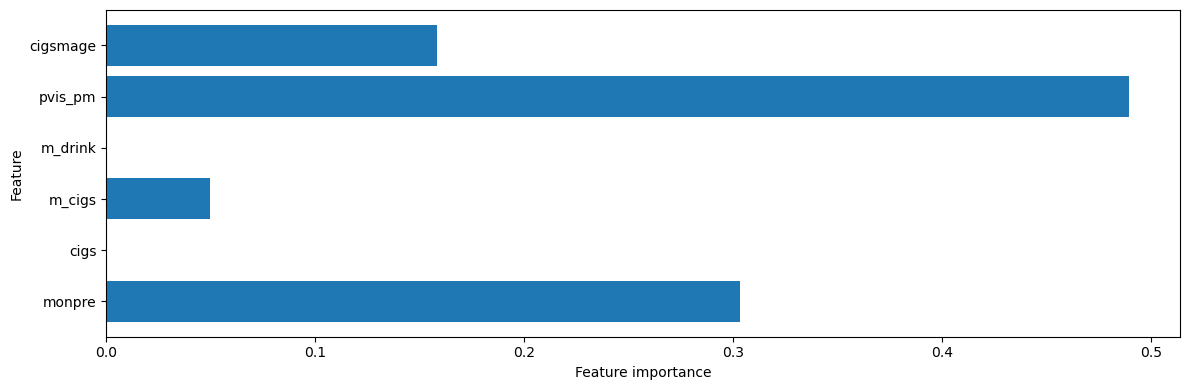


The model predicts 1.09% of babies to be born with low weight.


In [47]:
model(x_features = "coeff_high",
      y_feature = "low_bwght",
      
      # Instantiating model
      model     = DecisionTreeClassifier(
          # fixed parameters
          random_state              = 1836
          ,class_weight             = "balanced"
          ,max_features             = None
          ,min_samples_leaf         = 1
          ,min_impurity_decrease    = 0
          ,ccp_alpha                = 0
          
          # hypertuned parameters
          ,min_weight_fraction_leaf = 0.01
          ,min_samples_split        = 18
          ,max_leaf_nodes           = 45
          ,max_depth                = 10
          ,criterion                = "gini"
      
      # Naming Model & Selecting Output
      ),name              = "Decision Tree Classification"
      ,thresh             = 0.9    # threshold for classification
      ,thresh_results     = False  # showing probabilities
      ,tree               = False  # plotting tree
      ,feature_importance = True  # plotting feature importance plot
      ,cm                 = False) # confusion matrix display option

The fourth model used is a decision tree model. This model, fine-tuned using fixed and hyper-tuned parameters, achieves a remarkable balance between accurately predicting low birth weight cases and avoiding false alarms. With an accuracy of 25%, it shows a moderate ability to correctly identify at-risk infants among those it indicates. However, the recovery rate of 9.52% suggests that the model is limited in capturing a more comprehensive range of actual low birth weight cases, indicating a potential area for improvement. The model is characterized by high overall accuracy (93.93%) and high agreement between training and test datasets, reflecting its consistency. Despite these strengths, the decision to set a high threshold for classification results in a conservative prediction rate that identifies only 1.09% of infants as high-risk births, highlighting the model's cautious approach to flagging infants for further investigation.

According to the feature importance plot above, the two most essential features in modeling birthweight are `pvis_pm` and `monpre`.

The feature `pvis_pm`, which explains approximately 50% of the variance, emerges as the most predictive factor. This feature encapsulates the frequency and timing of prenatal care (calculated as the number of prenatal visits divided by the month when prenatal care started), signifying that comprehensive prenatal monitoring strongly correlates with healthy birthweight outcomes. This suggests that healthcare providers should enhance prenatal services to ensure they are frequent, high-quality, and start as early as possible during pregnancy. Strategies may include developing educational programs that stress the importance of regular prenatal visits, offering flexible appointment scheduling, and providing mobile health units to reach expectant mothers in remote areas.

In parallel, `monpre` - accounting for roughly 30% of the variance - significantly impacts birthweight, indicating the crucial role of the gestational period at which prenatal care is initiated. Early commencement of prenatal care allows for timely health interventions and educational support, which are vital for the health of both the mother and the developing fetus. An actionable insight for `monpre` would involve policy initiatives to reduce early prenatal care access barriers. This could affect public health messaging on the importance of prenatal care, policies that mandate insurance coverage for early prenatal visits, and community support programs that assist mothers in navigating the healthcare system.

Together, `pvis_pm` and `monpre` underscore the importance of early and consistent prenatal care as determinants of birthweight, and the insights provided by these features offer a roadmap for healthcare providers and policymakers to improve neonatal health outcomes.

<h3>Random Forest Classification</h3><br>

In [48]:
param_grid_rfc = {     
    "n_estimators": np.arange(100, 200, 1)                 # trees
    ,"min_weight_fraction_leaf": np.arange(0.005,
                                           0.015, 0.001)   # weight fraction
    ,"min_samples_split": np.arange(4, 15, 1)              # samples for split
    ,"max_leaf_nodes": np.arange(5, 100, 1)                # leaf nodes
    ,"max_depth": np.arange(7, 15, 1)}                     # tree depth

# Applying tuning function
#tune_and_display_results(
#    x_features = "coeff_high", # selecting x features
#    y_feature = "low_bwght",   # selecting y feature
#    model = RandomForestClassifier(
#        # fixed parameters
#        random_state           = 1836
#        ,n_jobs                = -1
#        ,class_weight          = "balanced"
#        ,min_samples_leaf      = 1
#        ,max_features          = None
#        ,bootstrap             = False
#        ,min_impurity_decrease = 0
#        ,ccp_alpha             = 0
#        ,criterion             = "gini"
#        
#    ),name     = "Random Forest Classification", # model & model name
#    parameters = param_grid_rfc,                 # grid of parameters to tune
#    n          = 5)                              # output of n best models


Top Tuned Random Forest Classification Score: 0.5751


,Model_Rank,Mean_Test_Score,SD_Test_Score,n_estimators,min_weight_fraction_leaf,min_samples_split,max_leaf_nodes,max_depth
5,1,0.575094,0.036825,151,0.01,10,76,10
89,2,0.572209,0.039879,143,0.01,8,85,13
80,2,0.572209,0.039879,125,0.01,10,72,11
56,2,0.572209,0.039879,133,0.01,11,66,13
55,2,0.572209,0.039879,171,0.01,9,88,13


In [49]:
model(x_features = "coeff_high",
      y_feature = "low_bwght",
      
      # Instantiating model
      model     = RandomForestClassifier(
          # fixed parameters 
          random_state              = 1836
          ,n_jobs                   = -1
          ,class_weight             = "balanced"
          ,min_samples_leaf         = 1
          ,max_features             = None
          ,bootstrap                = False
          ,min_impurity_decrease    = 0
          ,ccp_alpha                = 0
          ,criterion                = "gini"
          
          # hypertuned parameters  
          ,n_estimators             = 151
          ,min_weight_fraction_leaf = 0.01
          ,min_samples_split        = 10
          ,max_leaf_nodes           = 76
          ,max_depth                = 10
      
      # Naming Model & Selecting Output
      ),name              = "Random Forest Classification"
      ,thresh             = 0.9    # threshold for classification
      ,thresh_results     = False  # showing probabilities
      ,feature_importance = False  # plotting feature importance plot
      ,cm                 = False) # confusion matrix display option

    Model Name:     Random Forest Classification with coeff_high and threshold 0.9
    Train Score:    0.7638
    Test Score:     0.7427
    Train-Test Gap: 0.0211
    
    AUC:                              0.5374
    Accuracy ((TP+TN)/(TP+TN+FP+FN)): 0.9345
    Precision (TP/(TP+FP)):           0.2
    Recall/Sensitivity (TP/(TP+FN)):  0.0952
    Specificity (TN/(TN+FP)):         0.9795

The model predicts 1.09% of babies to be born with low weight.


The Random Forest Classification model employs an advanced ensemble learning technique, leveraging multiple decision trees to enhance prediction accuracy for low birth weight in infants. This model has been carefully calibrated with fixed and hyper-tuned parameters to effectively balance the sensitivity and specificity of predictions. Despite achieving an overall accuracy of 93.45% and a high level of consistency between training and test scores, indicating a reliable performance, its precision rate is only 20% (compared to 25% with a simple DTC). This suggests that while it can identify at-risk infants with some degree of accuracy, there's room for improvement in minimizing false positives. The recall rate of 9.52% points to the model's conservative nature in flagging low birth weight cases, potentially missing a broader segment of at-risk infants. Moreover, with a specificity of 97.95%, it demonstrates a solid ability to correctly classify non-at-risk (normal weight) cases. However, like previous models, this one also predicts a relatively small percentage (1.09%) of babies at risk, emphasizing a cautious approach.

<h3>GBM Classification</h3><br>

In [50]:
param_grid_gbm = {
    "subsample": np.arange(0.01, 0.2, 0.001),  # Subsample data fraction
    "n_estimators": np.arange(100, 800, 1),    # Number of trees
    "min_samples_split": np.arange(4, 15, 1),  # Min samples to split
    "min_impurity_decrease": np.arange(0, 0.5,
                                       0.01),  # Min impurity decrease
    "max_depth": np.arange(1, 15, 1),          # Tree max depth
    "learning_rate": np.arange(0, 100, 0.01),  # Learning rate
    "criterion": ["friedman_mse",
                  "squared_error"],            # Split criterion options
    "ccp_alpha": np.arange(0,0.02,0.001),      # Complexity control
}

# Applying tuning function
#tune_and_display_results(
#    x_features = "coeff_high", # selecting x features
#    y_feature = "low_bwght",   # selecting y feature
#    model = GradientBoostingClassifier(
#        # fixed parameters
#        random_state           = 1836
#        ,min_samples_leaf      = 1
#        ,max_features          = None
#        ,loss                  = "exponential"
#        
#    ),name     = "Gradient Boosting Classification", # model & model name
#    parameters = param_grid_gbm, # grid of parameters to tune
#    n          = 5)             # output of n best models


Top Tuned Gradient Boosting Classification Score: 0.526


,Model_Rank,Mean_Test_Score,SD_Test_Score,subsample,n_estimators,min_samples_split,min_impurity_decrease,max_depth,learning_rate,criterion,ccp_alpha
32,1,0.525952,0.019406,0.095,698,8,0.16,1,14.30,squared_error,0.005
42,2,0.524977,0.031990,0.183,597,4,0.24,1,86.42,friedman_mse,0.002
29,3,0.523756,0.041039,0.186,299,10,0.19,4,5.99,squared_error,0.014
77,4,0.521303,0.042422,0.138,443,7,0.08,1,91.42,squared_error,0.017
25,5,0.518764,0.019355,0.065,194,13,0.07,8,7.35,squared_error,0.004


In [51]:
model(
    x_features = "coeff_high",
    y_feature = "low_bwght",
    
    # Instantiating model
    model = GradientBoostingClassifier(
        # fixed parameters
        random_state           = 1836
        ,min_samples_leaf      = 1
        ,max_features          = None              # complexity parameter
        ,loss                  = "exponential"     # loss function
        
        # hyperparameter tuned
        ,subsample             = 0.095             # subsample fraction
        ,n_estimators          = 698               # number of trees
        ,min_samples_split     = 8                 # min samples to split
        ,min_impurity_decrease = 0.16              # min impurity decrease
        ,max_depth             = 1                 # tree max depth
        ,learning_rate         = 14.3              # learning rate
        ,criterion             = "squared_error"   # split criterion
        ,ccp_alpha             = 0.05              # pruning

    
      # Naming Model & Selecting Output
      ),name              = "Gradient Boosting Classification"
      ,thresh             = 9.999998e-01 # threshold for classification
      ,thresh_results     = False         # showing probabilities
      ,cm                 = False)        # confusion matrix display option

    Model Name:     Gradient Boosting Classification with coeff_high and threshold 0.9999998
    Train Score:    0.2791
    Test Score:     0.2694
    Train-Test Gap: 0.0097
    
    AUC:                              0.5161
    Accuracy ((TP+TN)/(TP+TN+FP+FN)): 0.9369
    Precision (TP/(TP+FP)):           0.1429
    Recall/Sensitivity (TP/(TP+FN)):  0.0476
    Specificity (TN/(TN+FP)):         0.9847

The model predicts 0.54% of babies to be born with low weight.


The Gradient gradient-boosting classification model utilizes a sophisticated approach that combines multiple predictive models to improve accuracy. This model has undergone extensive hyperparameter tuning, including adjustments to the learning rate, number of trees, and other parameters critical to optimizing its performance. Despite these efforts, the model exhibits a relatively low training (27.91%) and testing (26.94%) score, indicating challenges in capturing the complexity of the dataset with the chosen settings. Subsequently, this model does not need further consideration as all other models have significantly outperformed this model.

<h2>Part V: Model Results</h2><br>
Here, an overview of all model results is provided. X is selected as the final model.

In [52]:
# showing all model results
model_results.sort_values(by = "Precision", ascending = False)

,Model Name,train_RSQ,test_RSQ,tt_gap,AUC Score,Precision,Sensitivity,Specificity,True n_bwght,False low_bwght,False n_bwght,True low_bwght
2,KNN Classification,0.949,0.949,0.0,0.5238,1.0,0.0476,1.0,391,0,20,1
3,Decision Tree Classification,0.7638,0.7427,0.0211,0.5399,0.25,0.0952,0.9847,385,6,19,2
4,Random Forest Classification,0.7638,0.7427,0.0211,0.5374,0.2,0.0952,0.9795,383,8,19,2
0,Logistic Regression,0.7071,0.7063,0.0008,0.5161,0.1429,0.0476,0.9847,385,6,20,1
5,Gradient Boosting Classification,0.2791,0.2694,0.0097,0.5161,0.1429,0.0476,0.9847,385,6,20,1
1,Ridge Classification,0.6675,0.6335,0.034,0.5591,0.0667,0.4762,0.6419,251,140,11,10


In a healthcare setting focused on early intervention for infants at risk of low birth weight, the Logistic Regression model stands out due to its balance of accuracy, interpretability, and reliability. This model's low train-test gap (0.0008) indicates a stable performance between the training and testing data, suggesting it will perform reliably in real-world applications. Its interpretability is a crucial advantage; the model provides clear insights into how each factor contributes to the risk of low birth weight, making it easier for healthcare professionals to understand and act on the predictions. While not the highest in precision or specificity among all models considered, its reasonable performance metrics (precision of 0.1429 and specificity of 0.9847) ensure a solid foundation for identifying at-risk infants with minimal false positives.

The Logistic Regression model's capacity to elucidate the influence of various risk factors on low birth weight is invaluable for tailoring interventions and communicating with non-technical stakeholders, including parents and policymakers. This clarity helps in strategizing healthcare interventions by pinpointing actionable risk factors. Logistic Regression provides a compelling choice in scenarios where understanding the "why" behind a prediction is as crucial as the prediction itself.

Choosing Logistic Regression aligns with the goals of healthcare programs that prioritize actionable insights and transparent, evidence-based decision-making. This model's blend of accuracy, interpretability, and stability makes it particularly suitable for guiding early interventions in a healthcare context, where the stakes are high, and decisions must be accurate and explainable.

<h2>Part VI: Final Model Interpretation</h2><br>

In [53]:
model(x_features = "coeff_high",
      y_feature = "low_bwght",
      
      # Instantiating model
      model     = LogisticRegression(
          # fixed parameters
          random_state  = 1836
          ,class_weight = "balanced"
          ,solver       = "newton-cholesky" # due to lots of one hot encoding
          
          # hypertuned parameters
          ,penalty           = "l2"
          ,max_iter          = 611
          ,fit_intercept     = True
          ,C                 = 2
      
      # Naming Model & Selecting Output
      ),name         = "Logistic Regression",
      thresh         = 0.68,  # threshold for classification
      thresh_results = False, # showing probabilities
      coeff          = True,  # coefficient display option 
      cm             = True)  # confusion matrix display option         

    Model Name:     Logistic Regression with coeff_high and threshold 0.68
    Train Score:    0.7071
    Test Score:     0.7063
    Train-Test Gap: 0.0008
    
    AUC:                              0.5161
    Accuracy ((TP+TN)/(TP+TN+FP+FN)): 0.9369
    Precision (TP/(TP+FP)):           0.1429
    Recall/Sensitivity (TP/(TP+FN)):  0.0476
    Specificity (TN/(TN+FP)):         0.9847

Coefficents
---------------------------------------
     Feature  Coefficient
0  intercept        -0.11
1     monpre        -0.77
2       cigs         1.01
3     m_cigs         0.59
4    m_drink        -0.56
5    pvis_pm        -0.74
6   cigsmage        -0.86

The model predicts 1.09% of babies to be born with low weight.

  True Negatives (correct) 385           | False Positives (incorrect) 6  
  PREDICTED: NORMAL WEIGHT (low_bwght=0) | PREDICTED: LOW WEIGHT    (low_bwght=1)
  ACTUAL:    NORMAL WEIGHT (low_bwght=0) | ACTUAL:    NORMAL WEIGHT (low_bwght=0)
  ---------------------------------------|-------

The coefficients from the logistic regression model provide valuable insights into the factors affecting the likelihood of low birth weight in infants. The negative coefficient for the intercept (-0.11) serves as a baseline reference for the log odds of an infant being born with low birth weight without the other factors. A negative coefficient for `monpre` (-0.77) suggests that earlier prenatal visits are associated with a lower likelihood of low birth weight, emphasizing the importance of early and regular prenatal care. The positive coefficient for `cigs` (1.01) indicates a significant increase in the risk of low birth weight with maternal smoking, with each additional cigarette per day increasing the odds. The positive coefficient for `m_cigs` (0.59) implies that the absence of data on smoking is also associated with an increased risk, possibly reflecting unreported high smoking levels. Conversely, the negative coefficient for `m_drink` (-0.56) is somewhat counterintuitive, suggesting that missing data on drinking correlates with a decrease in the likelihood of low birth weight, which may require further investigation to understand underlying factors or biases.

The negative coefficients for `pvis_pm` (-0.74) and `cigsmage` (-0.86) indicate that more prenatal visits relative to the month prenatal care began and lower cigarette consumption relative to the mother's age is associated with decreased risks of low birth weight. These findings underscore the critical role of comprehensive prenatal care and the two sided effects of maternal smoking on fetal health dependent on age.

The coefficients from the logistic regression model, when compared with the results from the decision tree, provide an enhanced understanding of the factors affecting the likelihood of low birth weight in infants. The feature `pvis_pm` holds a significant negative coefficient of -0.74, reinforcing its established importance from the decision tree results, accounting for approximately 50% of the explained variance. This alignment between models highlights the inverse relationship between the adjusted frequency of prenatal visits and low birth weight, advocating for interventions to promote early and frequent prenatal care.

Likewise, the feature `monpre`, with a negative coefficient of -0.77, mirrors its substantial variance contribution of around 30%, as identified in the decision tree's feature importance plot. The consistency across different modeling approaches accentuates the impact of the timing of prenatal care commencement on birth weight, suggesting a focus on reducing barriers to accessing prenatal care from the earliest stages of pregnancy. 

Based on these insights, it is imperative to recommend that healthcare providers and public health initiatives prioritize early and regular prenatal care to mitigate the risks associated with low birth weight. Programs aimed at reducing maternal smoking habits should be emphasized, along with targeted interventions for populations at higher risk due to late initiation of prenatal care or lack of information on smoking and drinking habits. Such strategies could significantly reduce the incidence of low birth weight, with long-term benefits for infant health and development. Moreover, the association of missing data with risk factors highlights the need for thorough data collection and management in prenatal healthcare services to ensure accurate risk assessment and intervention planning.

In the context of predicting low birth weight in infants, the confusion matrix presented delineates the outcomes of predictions versus actual observations: False positives occur when the model incorrectly predicts an infant to have low birth weight when, in fact, they are of normal weight; this case shows 6 instances of such an error. On the other hand, false negatives are cases where the model predicts a normal weight for an infant who actually has low birth weight, with 20 instances noted. Controlling for false positives, as indicated by the low number (6) compared to false negatives (20), demonstrates a focus on precision, which is the proportion of true positives (correct low birth weight predictions) out of all positive predictions made by the model. The emphasis on correctly predicting low birth weight (true positives) while minimizing false positives underscores a strategic decision to ensure that resources, interventions, and further diagnostic evaluations are directed toward those infants most likely to be at risk.

This approach minimizes unnecessary interventions for infants not at risk (normal weight), thereby optimizing healthcare resources and reducing potential stress or harm to those infants and their families. The choice to prioritize precision (and thus control false positives) over sensitivity (which would require minimizing false negatives) reflects a deliberate trade-off, favoring the avoidance of over-diagnosis and the potential for unnecessary medical intervention. This control is essential in a healthcare setting, where the accuracy of diagnosis must be balanced against the emotional and financial costs of false alarms. By focusing on precision, the model aims to ensure that when a prediction of low birth weight is made, it is highly likely to be correct, thereby supporting targeted and efficient healthcare responses.

~~~                            
 ______   __   ____ _        ___        _____ _____ ____  _____      /_  __
| __ ) \ / /  / ___| |      / \ \      / /_ _| ____/ ___|| ____|    (_)  | \
|  _ \\ V /  | |   | |     / _ \ \ /\ / / | ||  _| \___ \|  _|       _   | |
| |_) || |   | |___| |___ / ___ \ V  V /  | || |___ ___) | |___     ( )  | |
|____/ |_|    \____|_____/_/   \_\_/\_/  |___|_____|____/|_____|    |/  /_/ 
                                                                
~~~

<br>